### 1. Setup & Imports

In [1]:
import os, re, glob, json, warnings
from pathlib import Path
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import h5py
from skimage.metrics import structural_similarity as ssim
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
from typing import Tuple
from collections import defaultdict

# 사용자 정의 모듈 불러오기
from transforms import CenterCropOrPad
from coil_compression import SCCCompressor, IdentityCompressor

warnings.filterwarnings("ignore", category=RuntimeWarning)
plt.rcParams['figure.dpi'] = 120

### 2. 경로 설정 & 파일 목록 생성

In [2]:

# FastMRI 데이터 루트 경로 (사용자에 맞게 조정)
DATA_DIR = Path('/home/swpants05/Desktop/2025_FastMri/Data')

# 파일 목록 함수
REG = re.compile(r"(brain|knee)_acc([48])_(\d+)\.h5")
LB_REG = re.compile(r"(brain|knee)_test(\d+)\.h5")


def list_files(split: str, data_type: str):
    if split in ('train','val'):
        pattern = DATA_DIR / split / data_type / '*.h5'
        files = sorted(glob.glob(str(pattern)))
    elif split == 'leaderboard':
        files = []
        for acc in ('acc4','acc8'):
            pattern = DATA_DIR / 'leaderboard' / acc / data_type / '*.h5'
            files += glob.glob(str(pattern))
        files = sorted(files)
    else:
        raise ValueError(f'Unknown split: {split}')
    return files

splits = ['train','val','leaderboard']
files = {sp: {'image': list_files(sp,'image'), 'kspace': list_files(sp,'kspace')} for sp in splits}

# 확인
print({sp: {dt: len(files[sp][dt]) for dt in files[sp]} for sp in splits})

{'train': {'image': 340, 'kspace': 340}, 'val': {'image': 60, 'kspace': 60}, 'leaderboard': {'image': 116, 'kspace': 116}}


### 3. Helper Functions

In [3]:
def load_h5(path, key):
    with h5py.File(path,'r') as f:
        return f[key][()]


def quick_ifft2(kc):
    # ifft2c in numpy
    return np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(kc, axes=(-2,-1)), norm='ortho'), axes=(-2,-1))


def rss(img, axis=0):
    return np.sqrt(np.sum(np.abs(img)**2, axis=axis))


def compute_recon(kspace, mask=None):
    # kspace: (C,H,W), mask: (W,) or None
    if mask is not None:
        # apply along last dim broadcast
        kspace = kspace * mask[np.newaxis, :, None]
    img_c = quick_ifft2(kspace)
    return rss(img_c, axis=0)


def compute_ssim(pred, ref):
    return ssim(pred, ref, data_range=ref.max()-ref.min())


def center_crop_or_pad(
    img: np.ndarray, target_shape: Tuple[int,int]
) -> np.ndarray:
    """
    img를 중앙 기준으로 target_shape로 맞춥니다.
     - img가 크면 중앙을 잘라내고
     - img가 작으면 0으로 패딩을 넣어 확대
    """
    h, w = img.shape
    th, tw = target_shape

    # 1) Crop (중앙 기준)
    if h > th:
        top = (h - th) // 2
        img = img[top:top+th, :]
    if w > tw:
        left = (w - tw) // 2
        img = img[:, left:left+tw]

    # 2) Pad (0값으로 양쪽에)
    h2, w2 = img.shape
    pad_h = max(th - h2, 0)
    pad_w = max(tw - w2, 0)
    pad_top    = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left   = pad_w // 2
    pad_right  = pad_w - pad_left

    if pad_h or pad_w:
        img = np.pad(
            img,
            ((pad_top, pad_bottom), (pad_left, pad_right)),
            mode='constant', constant_values=0
        )
    return img



### 1) Baseline: Fully-sampled vs Ground Truth & Undersampled vs GT

train Baseline:   0%|          | 0/340 [00:00<?, ?it/s]

val Baseline:   0%|          | 0/60 [00:00<?, ?it/s]

leaderboard Baseline:   0%|          | 0/116 [00:00<?, ?it/s]

/tmp/ipykernel_8694/1577063420.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0].boxplot([baseline_ssim[k] for k in order], labels=order, showmeans=True)


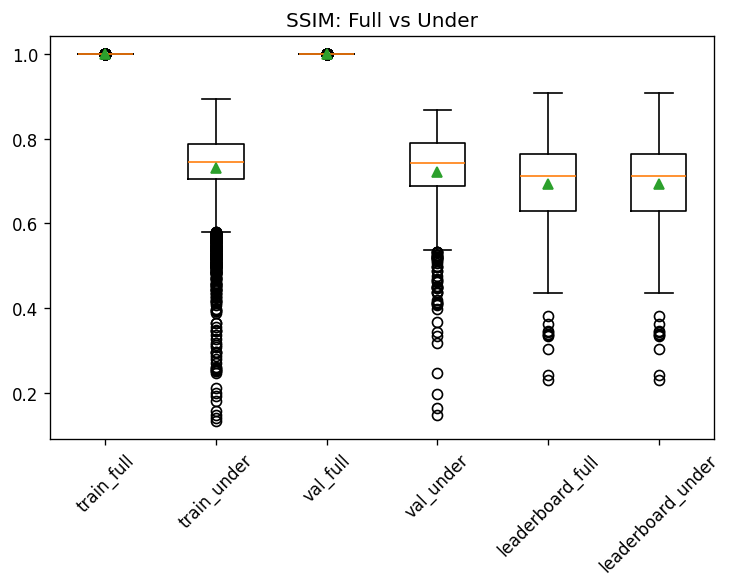

In [13]:
baseline_ssim = defaultdict(list)

for sp in splits:
    n_img = len(files[sp]['image'])
    n_ks  = len(files[sp]['kspace'])
    total = min(n_img, n_ks)
    for img_p, ks_p in tqdm(zip(files[sp]['image'], files[sp]['kspace']),
                             total=total, desc=f'{sp} Baseline'):
        # GT와 k-space 볼륨 로드
        with h5py.File(img_p,'r') as f_img:
            key_img  = 'image_label' if 'image_label' in f_img else 'image_grappa'
            img_vol  = f_img[key_img][()]          # (S, H_gt, W_gt)
        with h5py.File(ks_p,'r') as f_ks:
            ks_vol   = f_ks['kspace'][()]          # (S, C, H_k, W_k)
            mask     = f_ks['mask'][()]            # (H_k, W_k)

        for gt_slice, ks_slice in zip(img_vol, ks_vol):
            # 1) Fully-sampled
            rec_full = rss(quick_ifft2(ks_slice))
            # 2) Undersampled
            rec_under = rss(quick_ifft2(ks_slice * mask[np.newaxis, ...]))

            # 3) Shape mismatch 시 중앙 crop
            gt_shape = gt_slice.shape
            rec_full  = center_crop_or_pad(rec_full,  gt_shape)
            rec_under = center_crop_or_pad(rec_under, gt_shape)

            # 4) SSIM 계산
            baseline_ssim[f'{sp}_full'].append(
                compute_ssim(rec_full, gt_slice)
            )
            baseline_ssim[f'{sp}_under'].append(
                compute_ssim(rec_under, gt_slice)
            )

# 시각화
fig, ax = plt.subplots(1,2,figsize=(12,5))
order = ['train_full','train_under','val_full','val_under','leaderboard_full','leaderboard_under']
ax[0].boxplot([baseline_ssim[k] for k in order], labels=order, showmeans=True)
ax[0].set_title('SSIM: Full vs Under')
ax[0].tick_params(axis='x', rotation=45)
ax[1].set_visible(False)
plt.tight_layout()
plt.show()


### 2) Preprocessing Variants: SCC On/Off × Crop On/Off

train acc4 (sample 17/170):   0%|          | 0/17 [00:00<?, ?it/s]

train acc8 (sample 17/170):   0%|          | 0/17 [00:00<?, ?it/s]

val acc4 (sample 3/30):   0%|          | 0/3 [00:00<?, ?it/s]

val acc8 (sample 3/30):   0%|          | 0/3 [00:00<?, ?it/s]

leaderboard acc4 (sample 5/58):   0%|          | 0/5 [00:00<?, ?it/s]

leaderboard acc8 (sample 5/58):   0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_14994/3347793281.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=variant_keys, showmeans=True)


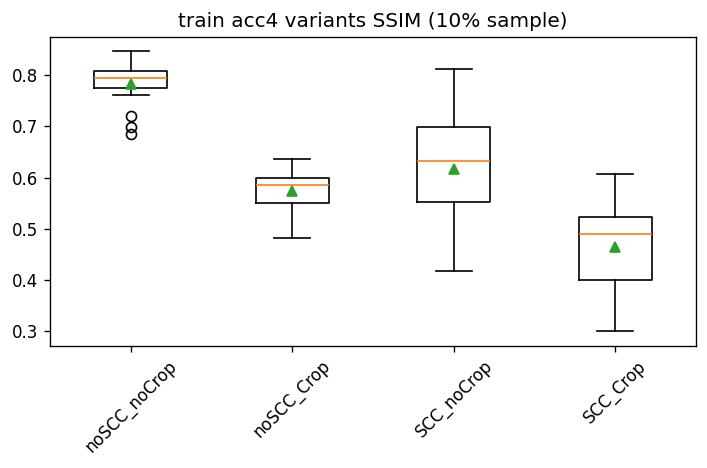

/tmp/ipykernel_14994/3347793281.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=variant_keys, showmeans=True)


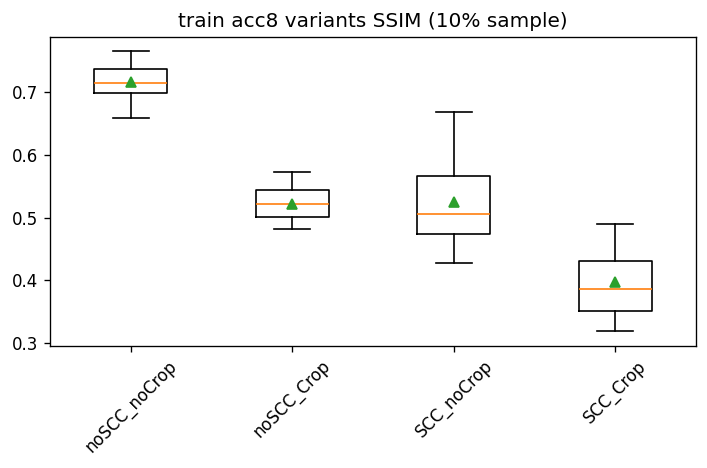

/tmp/ipykernel_14994/3347793281.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=variant_keys, showmeans=True)


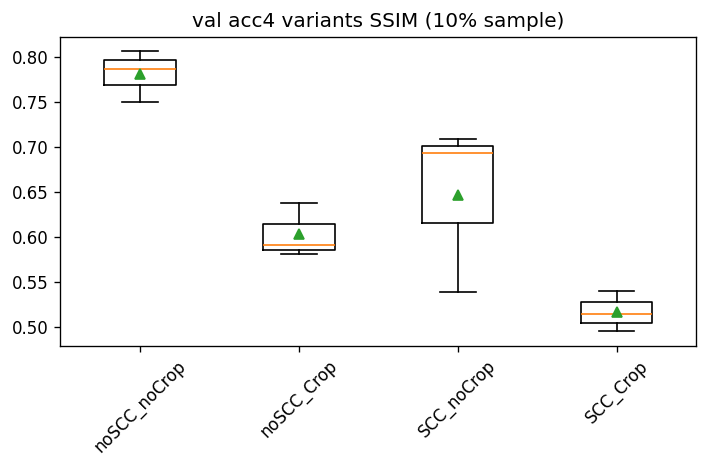

/tmp/ipykernel_14994/3347793281.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=variant_keys, showmeans=True)


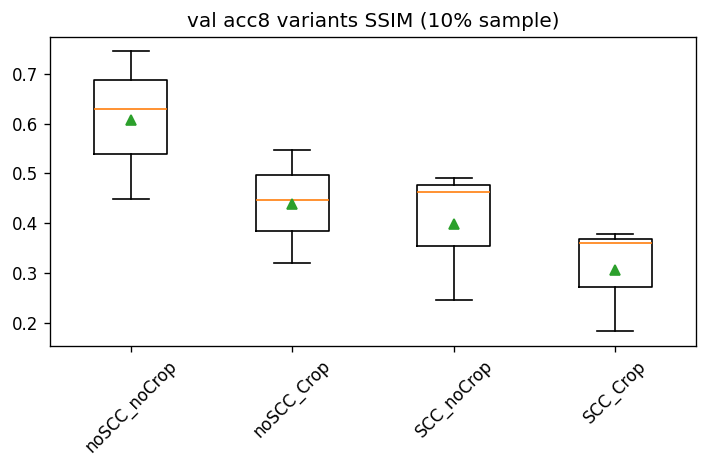

/tmp/ipykernel_14994/3347793281.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=variant_keys, showmeans=True)


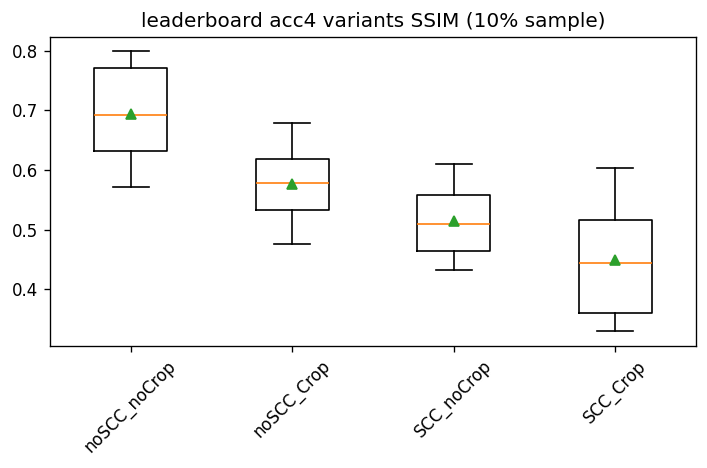

/tmp/ipykernel_14994/3347793281.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=variant_keys, showmeans=True)


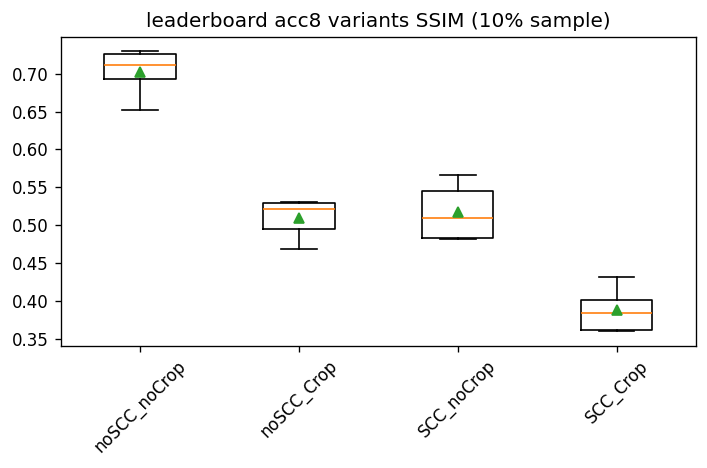

In [6]:
import random
from tqdm.auto import tqdm
from collections import defaultdict

# (중략) 기존 import, 함수 정의부는 그대로 두세요.

random.seed(42)  # 재현 가능한 샘플링을 위해 시드 고정

results = defaultdict(list)
variant_keys = ['noSCC_noCrop','noSCC_Crop','SCC_noCrop','SCC_Crop']
crop_size = (320,320)

for sp in splits:
    for acc in ('4','8'):
        # --- 1) (image, kspace) 쌍 수집 및 1/10 샘플링 ---
        all_pairs = [
            (img_p, ks_p)
            for img_p, ks_p in zip(files[sp]['image'], files[sp]['kspace'])
            if f'acc{acc}' in ks_p
        ]
        sample_size = max(1, int(len(all_pairs) * 0.1))
        sampled_pairs = random.sample(all_pairs, sample_size)

        # --- 2) 샘플링된 쌍만 순회하며 계산 ---
        iterator = tqdm(sampled_pairs,
                        desc=f'{sp} acc{acc} (sample {sample_size}/{len(all_pairs)})')
        for img_p, ks_p in iterator:
            # load volume
            with h5py.File(img_p,'r') as f_img:
                key_img = 'image_label' if 'image_label' in f_img else 'image_grappa'
                img_vol = f_img[key_img][()]       # (S, H_gt, W_gt)
            with h5py.File(ks_p,'r') as f_ks:
                ks_vol = f_ks['kspace'][()]        # (S, C, H_k, W_k)
                mask   = f_ks['mask'][()].flatten()# (H_k*W_k,)

            # volume 내에서도 슬라이스를 1/10 샘플링하고 싶다면 여기에 추가 가능
            slice_pairs = list(zip(img_vol, ks_vol))
            slice_sample_size = max(1, int(len(slice_pairs) * 0.1))
            slice_samples = random.sample(slice_pairs, slice_sample_size)

            for gt_slice, ks_slice in slice_samples:
                # apply global mask
                ks_masked_np = ks_slice * mask[np.newaxis, ...]

                # variants
                for scc_on in (False, True):
                    compressor = SCCCompressor(target_coils=4) if scc_on else IdentityCompressor()
                    for crop_on in (False, True):
                        key = f"{'SCC' if scc_on else 'noSCC'}_{'Crop' if crop_on else 'noCrop'}"

                        # 1) to torch
                        ks_t = torch.from_numpy(ks_masked_np).to(torch.complex64)

                        # 2) optional crop
                        if crop_on:
                            _, ks_t, _, _, _, _ = CenterCropOrPad(target_size=crop_size)(
                                torch.from_numpy(mask).float(), ks_t, None, {}, '', 0
                            )
                        # 3) coil compression
                        _, ks_t, _, _, _, _ = compressor(torch.from_numpy(mask).float(), ks_t, None, {}, '', 0)

                        # 4) back to numpy & recon
                        ks_cmp = ks_t.numpy()
                        recon = compute_recon(ks_cmp)
                        rec_match = center_crop_or_pad(recon, gt_slice.shape)

                        # 5) SSIM 저장
                        results[(sp,acc,key)].append(
                            compute_ssim(rec_match, gt_slice)
                        )

# 시각화 (기존과 동일)
for sp in splits:
    for acc in ('4','8'):
        fig, ax = plt.subplots(figsize=(6,4))
        data = [results[(sp,acc,k)] for k in variant_keys]
        ax.boxplot(data, labels=variant_keys, showmeans=True)
        ax.set_title(f'{sp} acc{acc} variants SSIM (10% sample)')
        ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()


### 3) SCC Coil Count Spectrum (1..10)

train acc4 (files 17/170):   0%|          | 0/17 [00:00<?, ?it/s]

train acc8 (files 17/170):   0%|          | 0/17 [00:00<?, ?it/s]

val acc4 (files 3/30):   0%|          | 0/3 [00:00<?, ?it/s]

val acc8 (files 3/30):   0%|          | 0/3 [00:00<?, ?it/s]

leaderboard acc4 (files 5/58):   0%|          | 0/5 [00:00<?, ?it/s]

leaderboard acc8 (files 5/58):   0%|          | 0/5 [00:00<?, ?it/s]

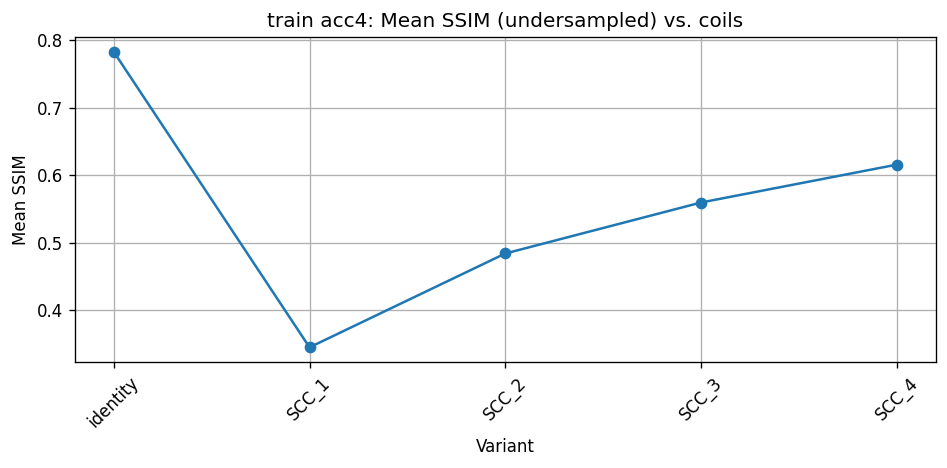

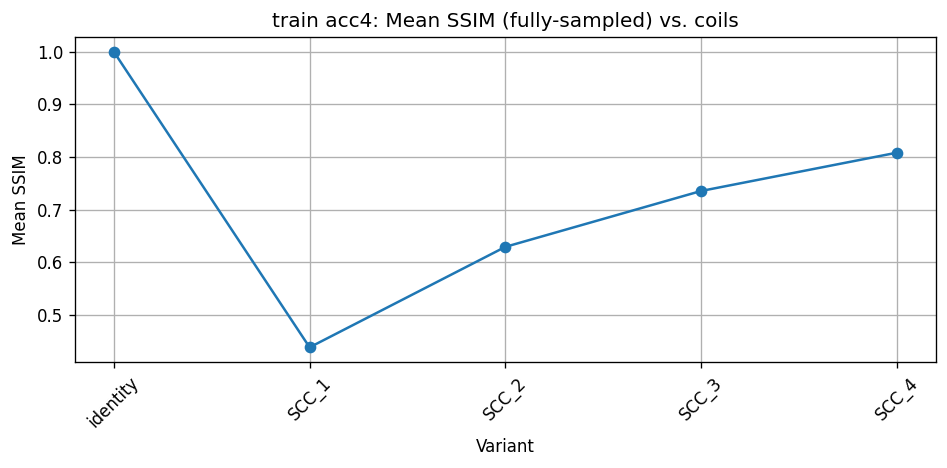

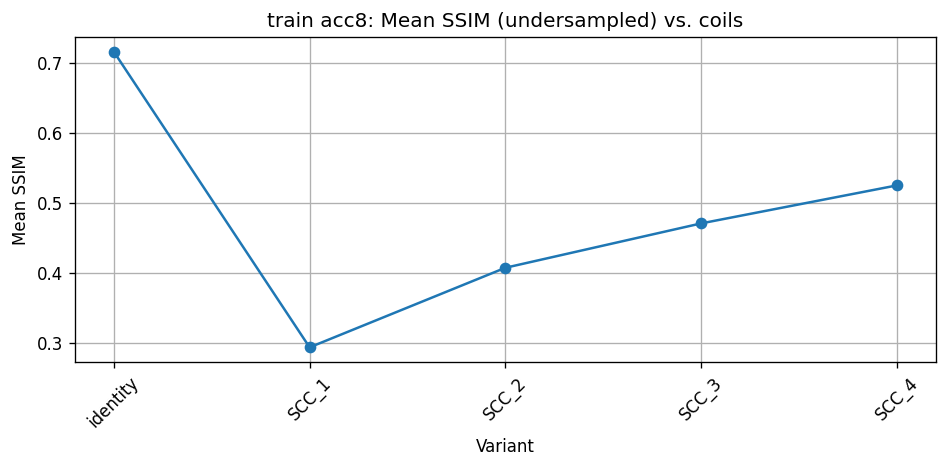

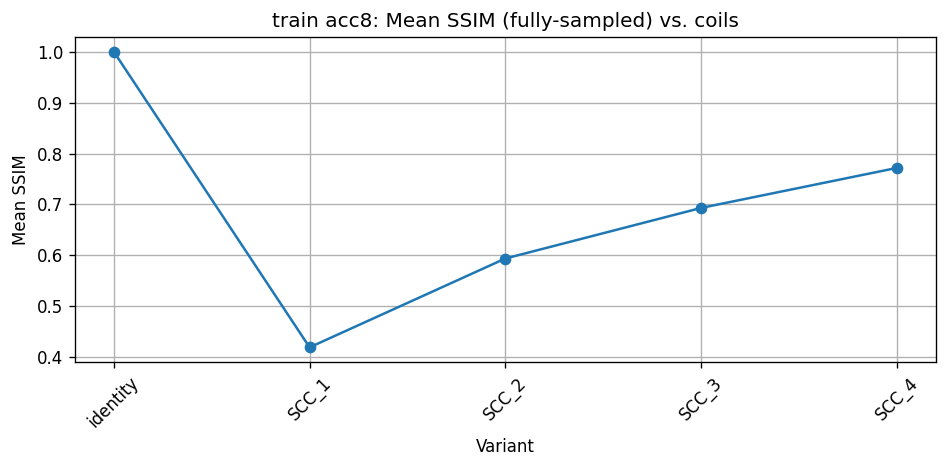

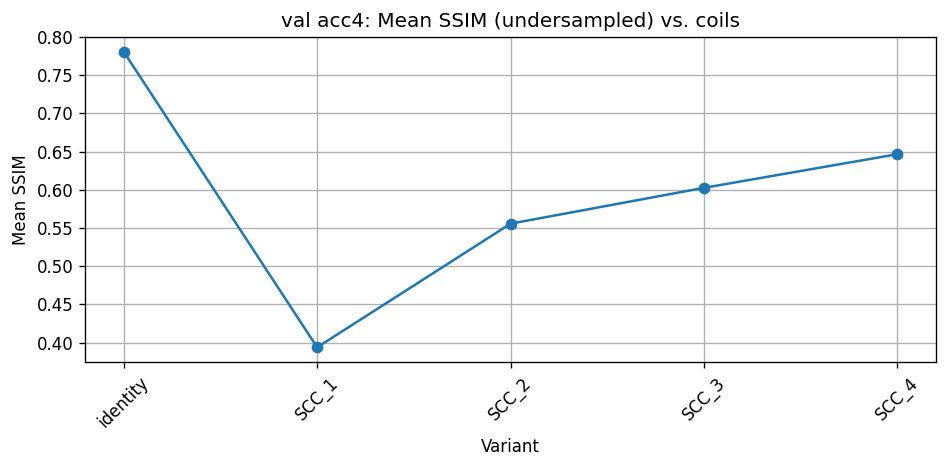

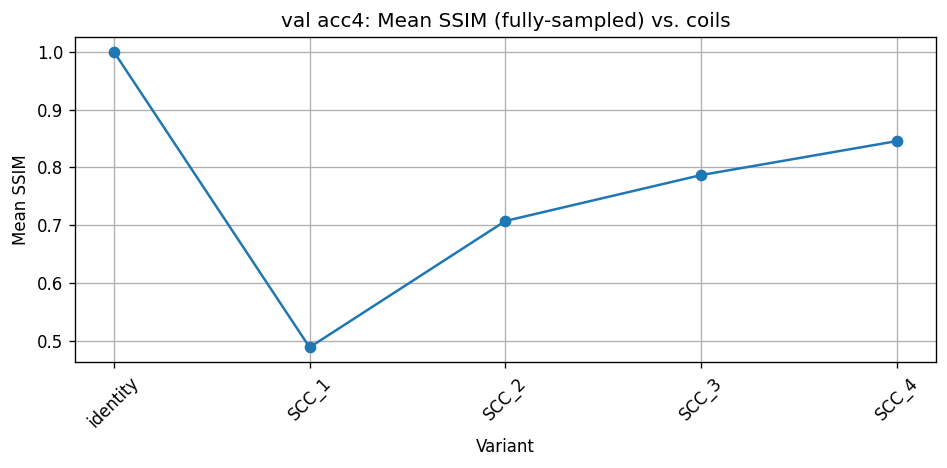

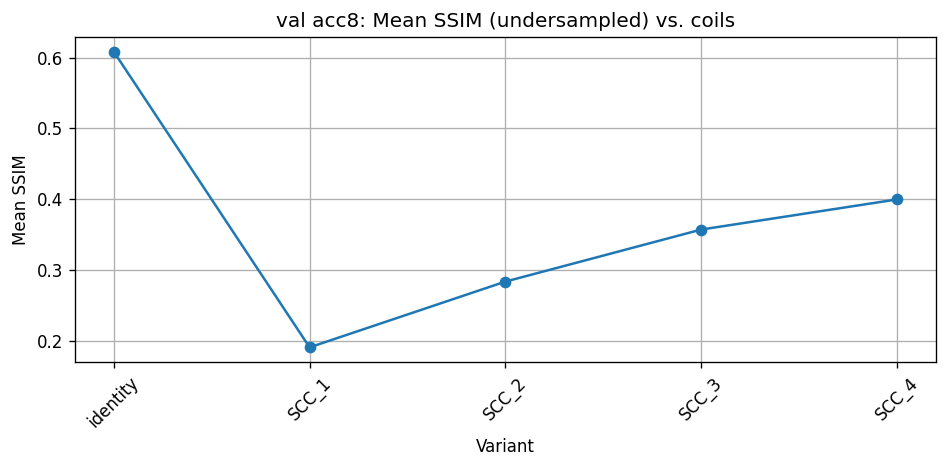

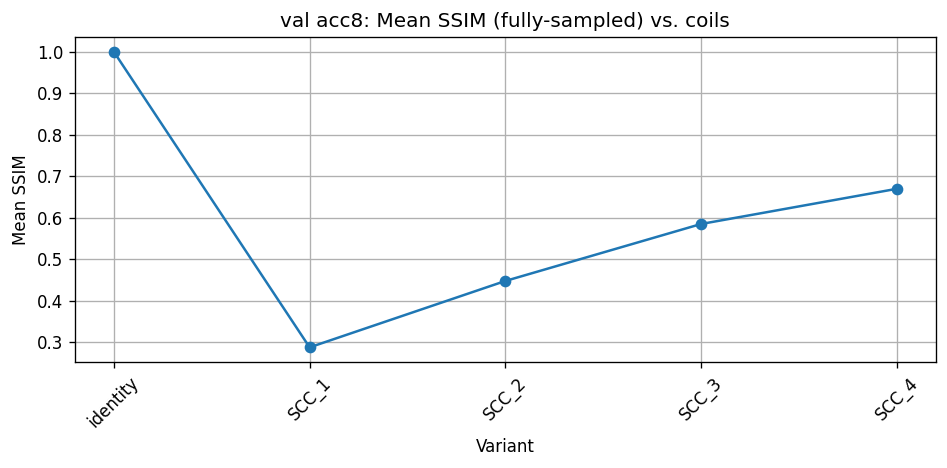

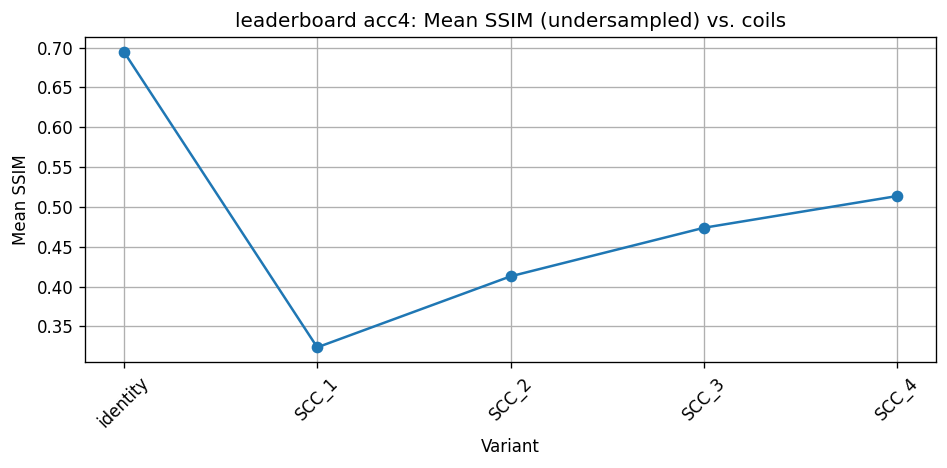

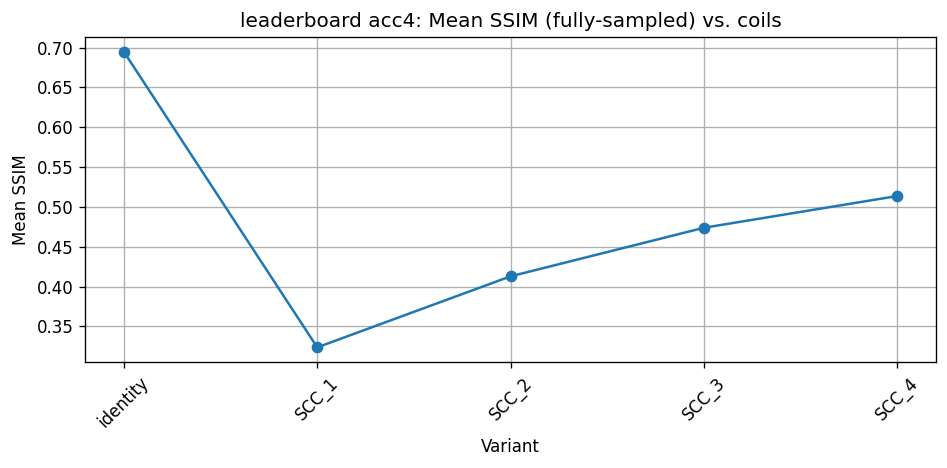

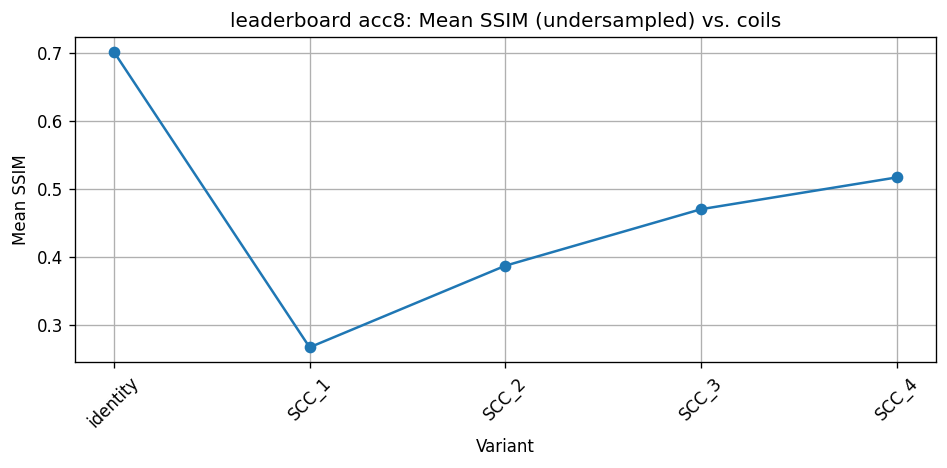

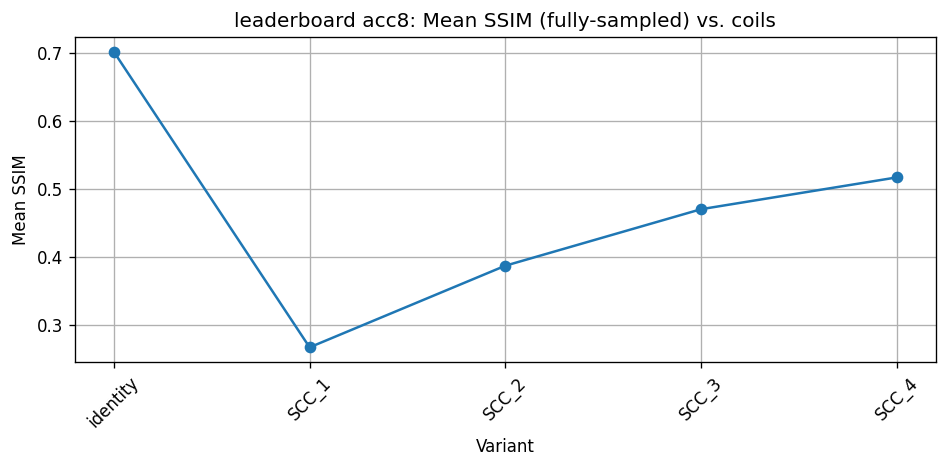

In [10]:
import random
from tqdm.auto import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

# (기존의 import, compute_recon, compute_ssim, center_crop_or_pad 등은 그대로 두세요)

random.seed(42)

# 실험 변수
coil_range   = list(range(1, 5))   # SCC target_coils = 1..8
sample_ratio = 0.1                 # 10% 샘플링

# 결과 저장: 
# results[(split, acc, 'under', variant)] = [ssim ...]
# results[(split, acc, 'full',  variant)] = [ssim ...]
results = defaultdict(list)

for sp in splits:
    for acc in ('4','8'):
        # 1) 파일 쌍 10% 샘플링
        all_pairs = [
            (img_p, ks_p)
            for img_p, ks_p in zip(files[sp]['image'], files[sp]['kspace'])
            if f'acc{acc}' in ks_p
        ]
        sample_size   = max(1, int(len(all_pairs) * sample_ratio))
        sampled_pairs = random.sample(all_pairs, sample_size)

        pbar = tqdm(sampled_pairs, desc=f'{sp} acc{acc} (files {sample_size}/{len(all_pairs)})')
        for img_p, ks_p in pbar:
            # 볼륨 로드
            with h5py.File(img_p,'r') as f_img:
                key_img = 'image_label' if 'image_label' in f_img else 'image_grappa'
                img_vol = f_img[key_img][()]       # (S, H, W)
            with h5py.File(ks_p,'r') as f_ks:
                ks_vol   = f_ks['kspace'][()]      # (S, C, Hk, Wk)
                mask_2d  = f_ks['mask'][()]        # (Hk, Wk)
                mask_flat= mask_2d.flatten()       # (Hk*Wk,)

            # 슬라이스 10% 샘플링
            slice_pairs       = list(zip(img_vol, ks_vol))
            slice_sample_size = max(1, int(len(slice_pairs) * sample_ratio))
            slice_samples     = random.sample(slice_pairs, slice_sample_size)

            for gt_slice, ks_slice in slice_samples:
                # 1) prepare torch mask for compressor
                mask_t = torch.from_numpy(mask_flat).float()

                # 2) 원본 k-space / undersampled k-space
                ks_full_np  = ks_slice
                ks_under_np = ks_slice * mask_2d[np.newaxis, ...]

                # ---- identity (no SCC) ----
                # undersampled
                rec_under = compute_recon(ks_under_np)
                s_under = compute_ssim(center_crop_or_pad(rec_under, gt_slice.shape), gt_slice)
                results[(sp, acc, 'under', 'identity')].append(s_under)

                # fully-sampled
                rec_full = compute_recon(ks_full_np)
                s_full = compute_ssim(center_crop_or_pad(rec_full, gt_slice.shape), gt_slice)
                results[(sp, acc, 'full', 'identity')].append(s_full)

                # ---- SCC 압축 스펙트럼 ----
                for c in coil_range:
                    compressor = SCCCompressor(target_coils=c)

                    # ** undersampled → SCC → recon **
                    ks_t = torch.from_numpy(ks_under_np).to(torch.complex64)
                    _, ks_t, *_ = compressor(mask_t, ks_t, None, {}, '', 0)
                    rec_u_cmp = compute_recon(ks_t.numpy())
                    s_u_cmp = compute_ssim(center_crop_or_pad(rec_u_cmp, gt_slice.shape), gt_slice)
                    results[(sp, acc, 'under', f'SCC_{c}')].append(s_u_cmp)

                    # ** fully-sampled → SCC → recon **
                    ks_t = torch.from_numpy(ks_full_np).to(torch.complex64)
                    _, ks_t, *_ = compressor(mask_t, ks_t, None, {}, '', 0)
                    rec_f_cmp = compute_recon(ks_t.numpy())
                    s_f_cmp = compute_ssim(center_crop_or_pad(rec_f_cmp, gt_slice.shape), gt_slice)
                    results[(sp, acc, 'full', f'SCC_{c}')].append(s_f_cmp)

# ---- 시각화 ----
variants = ['identity'] + [f'SCC_{c}' for c in coil_range]

for sp in splits:
    for acc in ('4','8'):
        # undersampled plot
        plt.figure(figsize=(8,4))
        means_u = [np.mean(results[(sp,acc,'under',v)]) for v in variants]
        plt.plot(variants, means_u, marker='o')
        plt.title(f'{sp} acc{acc}: Mean SSIM (undersampled) vs. coils')
        plt.xlabel('Variant')
        plt.ylabel('Mean SSIM')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # fully-sampled plot
        plt.figure(figsize=(8,4))
        means_f = [np.mean(results[(sp,acc,'full',v)]) for v in variants]
        plt.plot(variants, means_f, marker='o')
        plt.title(f'{sp} acc{acc}: Mean SSIM (fully-sampled) vs. coils')
        plt.xlabel('Variant')
        plt.ylabel('Mean SSIM')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


할 수 있는거 다 해본 경우
 - 만약 coil 개수가 11개다 그러면 1~11로 compression해본거임

In [21]:
import random
from tqdm.auto import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
import h5py

# (기존의 compute_recon, compute_ssim, center_crop_or_pad 함수는 그대로 쓰세요)
# from transforms import CenterCropOrPad

random.seed(42)

# 실험 설정
splits       = ['train', 'val', 'leaderboard']
crop_sizes   = [(256,256), (320,320), (384,384), (448,448), (640,384)]
sample_ratio = 0.2   # 20% 볼륨 샘플링

# 결과 저장: results[(split, acc, sampling, crop_size)] = [ssim, ...]
crop_ssim = defaultdict(list)

for sp in splits:
    for acc in ('4','8'):
        # 1) 볼륨(파일 쌍) 20% 샘플링
        all_pairs = [
            (img_p, ks_p)
            for img_p, ks_p in zip(files[sp]['image'], files[sp]['kspace'])
            if f'acc{acc}' in ks_p
        ]
        sample_size   = max(1, int(len(all_pairs) * sample_ratio))
        sampled_pairs = random.sample(all_pairs, sample_size)

        for size in crop_sizes:
            ccp  = CenterCropOrPad(target_size=size)
            desc = f'{sp}-acc{acc}-crop{size} ({sample_size}/{len(all_pairs)})'
            for img_p, ks_p in tqdm(sampled_pairs, desc=desc):
                # --- Load volumes ---
                with h5py.File(img_p,'r') as f_img:
                    key_img = 'image_label' if 'image_label' in f_img else 'image_grappa'
                    img_vol = f_img[key_img][()]         # (S, H_gt, W_gt)

                with h5py.File(ks_p,'r') as f_ks:
                    ks_vol = f_ks['kspace'][()]          # (S, C, Hk, Wk)
                    mask   = f_ks['mask'][()]            # (Wk,)

                # Undersample 적용
                ks_under = ks_vol * mask[np.newaxis, np.newaxis, np.newaxis, :]

                for slice_idx in range(ks_vol.shape[0]):
                    gt = img_vol[slice_idx]     # (H_gt, W_gt)

                    # -- undersampled case --
                    k_u = ks_under[slice_idx]   # (C, Hk, Wk)
                    # to torch for crop
                    mask_t = torch.from_numpy(mask).float()
                    k_u_t  = torch.from_numpy(k_u).to(torch.complex64)
                    # crop → back to k-space
                    _, k2_u, *_ = ccp(mask_t, k_u_t, None, {}, '', slice_idx)
                    k2u = k2_u.numpy()
                    # recon & shape-match
                    rec_u    = compute_recon(k2u)
                    rec_u_sm = center_crop_or_pad(rec_u, gt.shape)
                    crop_ssim[(sp, acc, 'under', size)].append(
                        compute_ssim(rec_u_sm, gt)
                    )

                    # -- fully-sampled case --
                    k_f = ks_vol[slice_idx]
                    k_f_t = torch.from_numpy(k_f).to(torch.complex64)
                    _, k2_f, *_ = ccp(mask_t, k_f_t, None, {}, '', slice_idx)
                    k2f = k2_f.numpy()
                    rec_f    = compute_recon(k2f)
                    rec_f_sm = center_crop_or_pad(rec_f, gt.shape)
                    crop_ssim[(sp, acc, 'full', size)].append(
                        compute_ssim(rec_f_sm, gt)
                    )

# --- 시각화: undersampled vs fully-sampled 각각 boxplot ---
for sp in splits:
    for acc in ('4','8'):
        for case in ('under','full'):
            fig, ax = plt.subplots(figsize=(6,4))
            data = [crop_ssim[(sp, acc, case, sz)] for sz in crop_sizes]
            labels = [f"{h}×{w}" for h,w in crop_sizes]
            ax.boxplot(data, labels=labels, showmeans=True)
            ax.set_title(f'{sp} acc{acc} ({case}): SSIM vs crop size')
            ax.tick_params(axis='x', rotation=45)
            plt.tight_layout()
            plt.show()


train-acc4-crop(256, 256) (34/170):   0%|          | 0/34 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

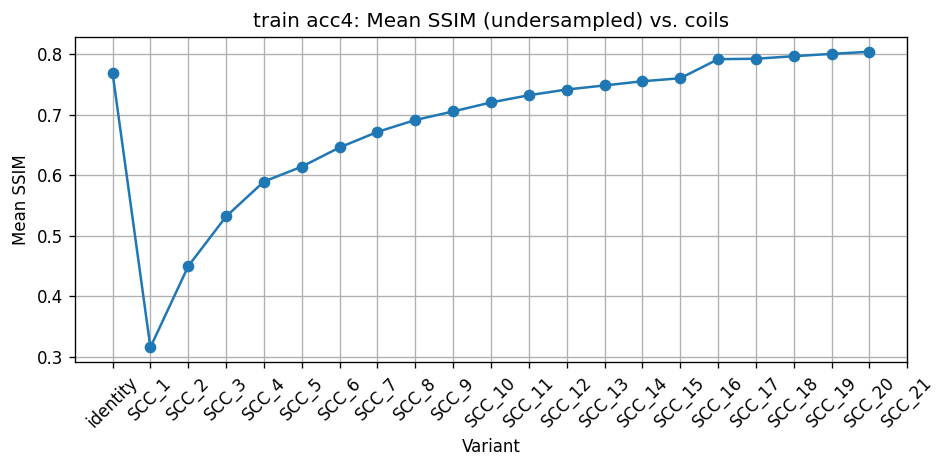

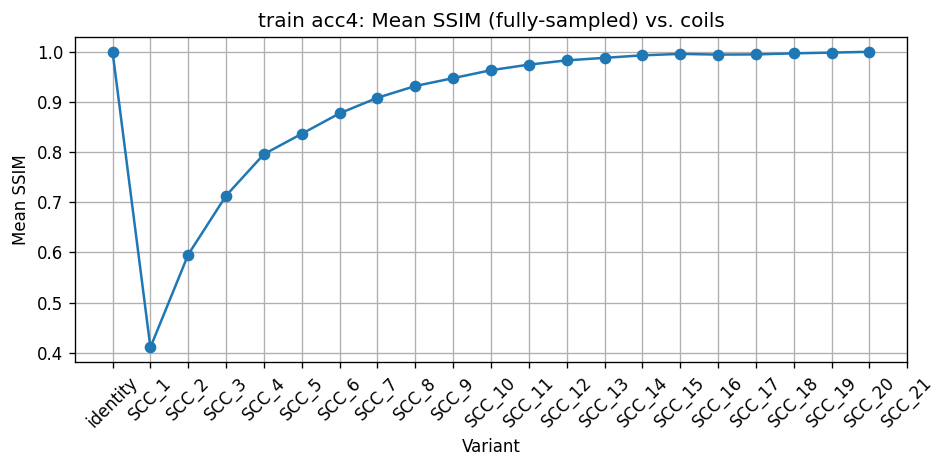

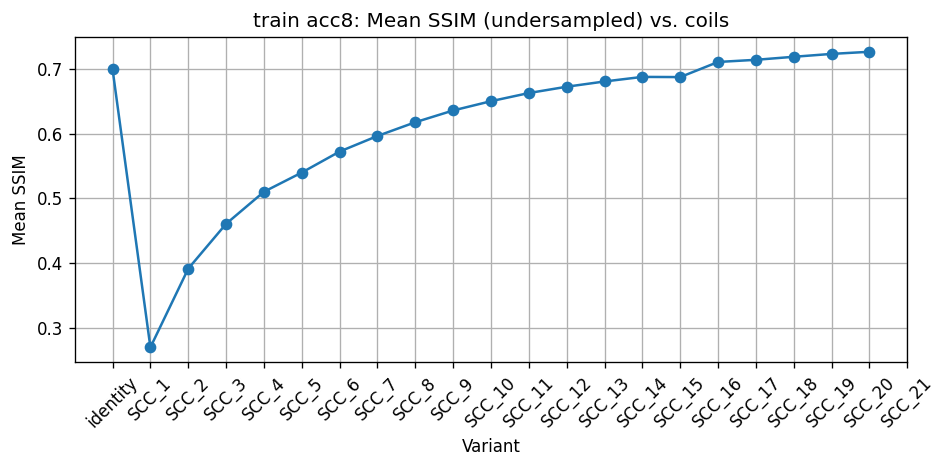

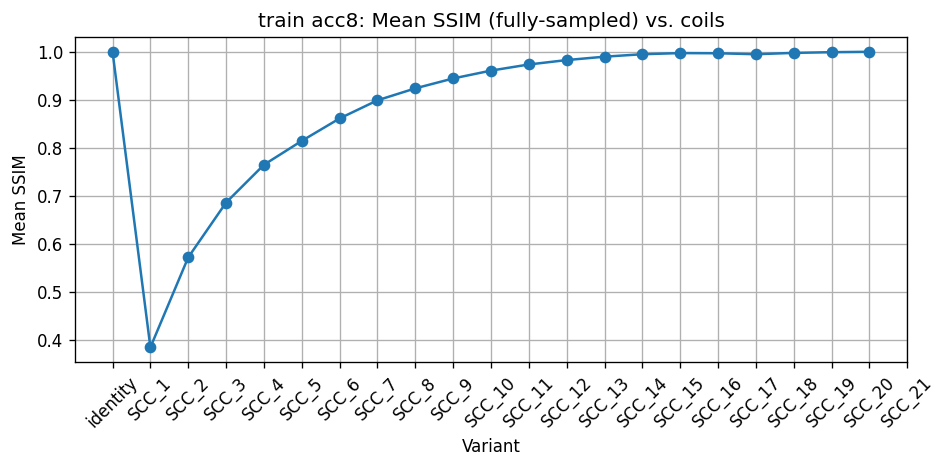

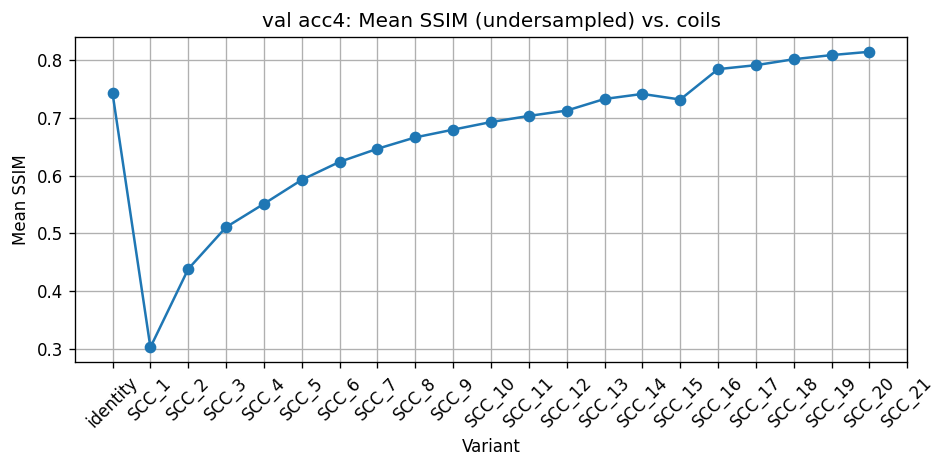

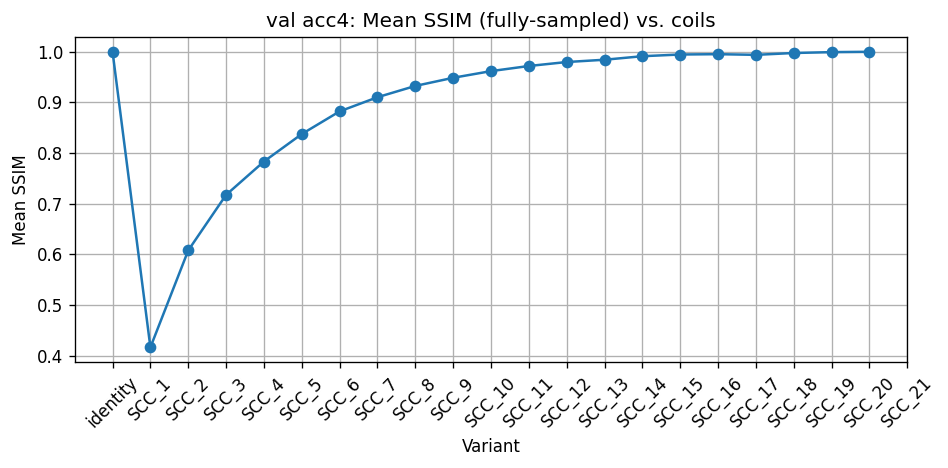

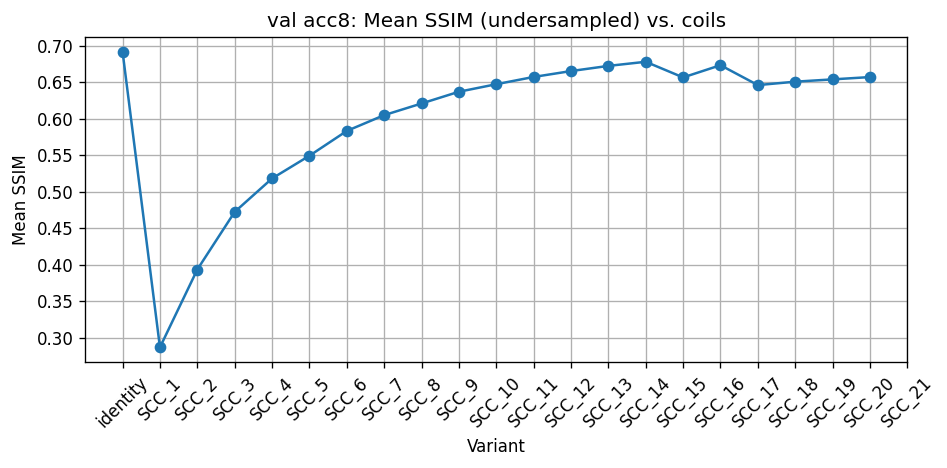

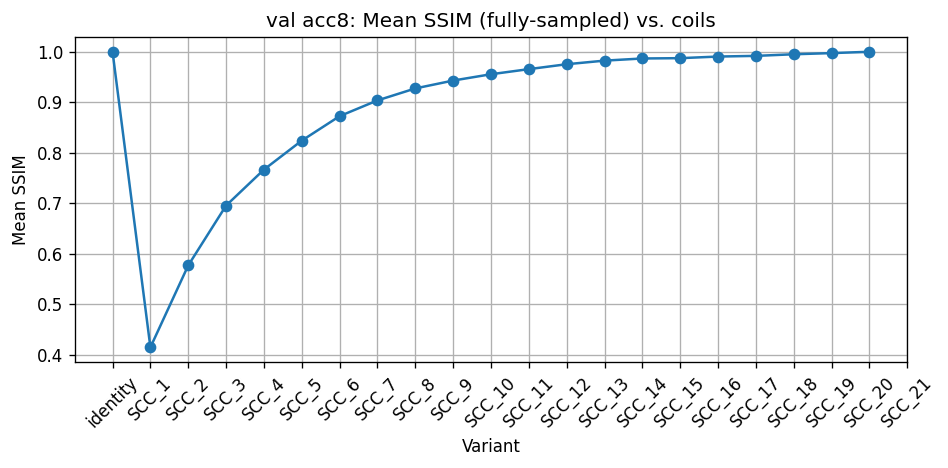

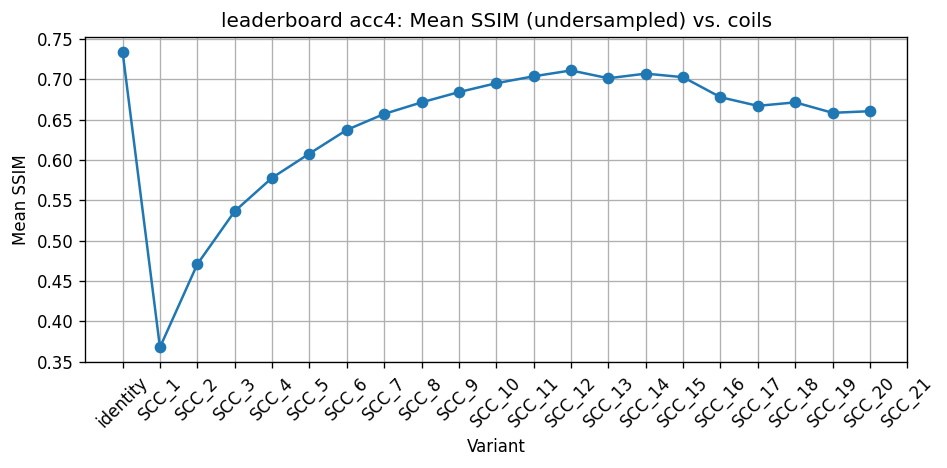

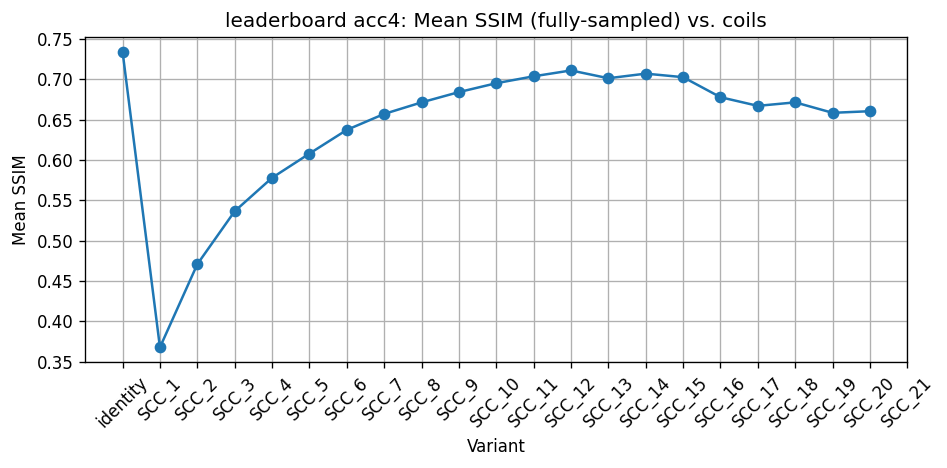

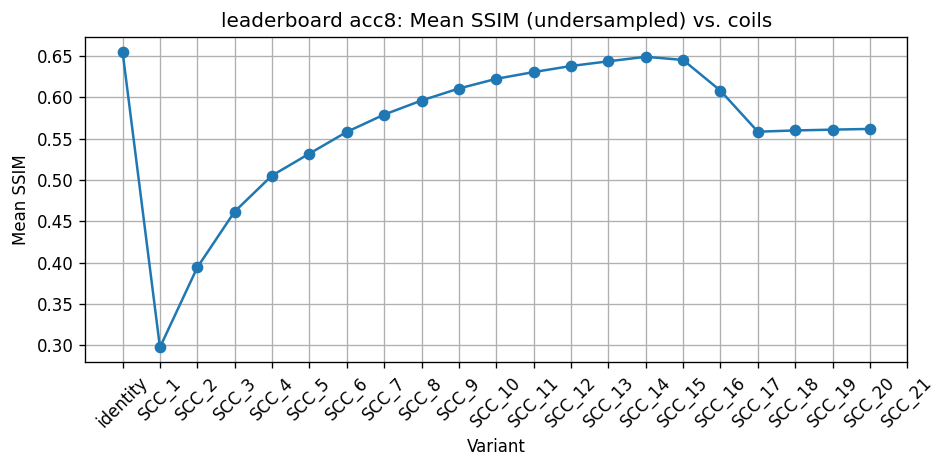

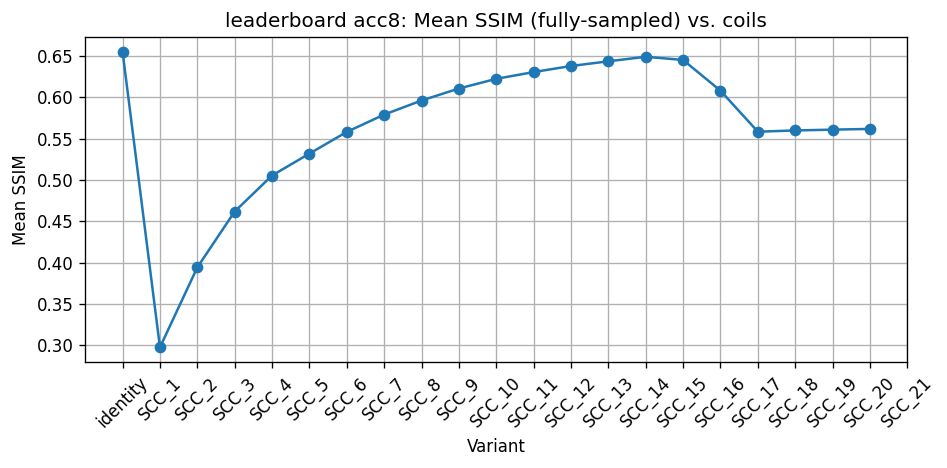

In [13]:

coil_range   = list(range(1, 30))   # SCC target_coils = 1..8
# ---- 시각화 ----
variants = ['identity'] + [f'SCC_{c}' for c in coil_range]

for sp in splits:
    for acc in ('4','8'):
        # undersampled plot
        plt.figure(figsize=(8,4))
        means_u = [np.mean(results[(sp,acc,'under',v)]) for v in variants]
        plt.plot(variants, means_u, marker='o')
        plt.title(f'{sp} acc{acc}: Mean SSIM (undersampled) vs. coils')
        plt.xlabel('Variant')
        plt.ylabel('Mean SSIM')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # fully-sampled plot
        plt.figure(figsize=(8,4))
        means_f = [np.mean(results[(sp,acc,'full',v)]) for v in variants]
        plt.plot(variants, means_f, marker='o')
        plt.title(f'{sp} acc{acc}: Mean SSIM (fully-sampled) vs. coils')
        plt.xlabel('Variant')
        plt.ylabel('Mean SSIM')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


### 4) Crop-Size Spectrum

train-acc4-crop(256, 256) (34/170):   0%|          | 0/34 [00:00<?, ?it/s]

train-acc4-crop(320, 320) (34/170):   0%|          | 0/34 [00:00<?, ?it/s]

train-acc4-crop(384, 384) (34/170):   0%|          | 0/34 [00:00<?, ?it/s]

train-acc4-crop(448, 448) (34/170):   0%|          | 0/34 [00:00<?, ?it/s]

train-acc4-crop(640, 384) (34/170):   0%|          | 0/34 [00:00<?, ?it/s]

train-acc8-crop(256, 256) (34/170):   0%|          | 0/34 [00:00<?, ?it/s]

train-acc8-crop(320, 320) (34/170):   0%|          | 0/34 [00:00<?, ?it/s]

train-acc8-crop(384, 384) (34/170):   0%|          | 0/34 [00:00<?, ?it/s]

train-acc8-crop(448, 448) (34/170):   0%|          | 0/34 [00:00<?, ?it/s]

train-acc8-crop(640, 384) (34/170):   0%|          | 0/34 [00:00<?, ?it/s]

val-acc4-crop(256, 256) (6/30):   0%|          | 0/6 [00:00<?, ?it/s]

val-acc4-crop(320, 320) (6/30):   0%|          | 0/6 [00:00<?, ?it/s]

val-acc4-crop(384, 384) (6/30):   0%|          | 0/6 [00:00<?, ?it/s]

val-acc4-crop(448, 448) (6/30):   0%|          | 0/6 [00:00<?, ?it/s]

val-acc4-crop(640, 384) (6/30):   0%|          | 0/6 [00:00<?, ?it/s]

val-acc8-crop(256, 256) (6/30):   0%|          | 0/6 [00:00<?, ?it/s]

val-acc8-crop(320, 320) (6/30):   0%|          | 0/6 [00:00<?, ?it/s]

val-acc8-crop(384, 384) (6/30):   0%|          | 0/6 [00:00<?, ?it/s]

val-acc8-crop(448, 448) (6/30):   0%|          | 0/6 [00:00<?, ?it/s]

val-acc8-crop(640, 384) (6/30):   0%|          | 0/6 [00:00<?, ?it/s]

leaderboard-acc4-crop(256, 256) (11/58):   0%|          | 0/11 [00:00<?, ?it/s]

leaderboard-acc4-crop(320, 320) (11/58):   0%|          | 0/11 [00:00<?, ?it/s]

leaderboard-acc4-crop(384, 384) (11/58):   0%|          | 0/11 [00:00<?, ?it/s]

leaderboard-acc4-crop(448, 448) (11/58):   0%|          | 0/11 [00:00<?, ?it/s]

leaderboard-acc4-crop(640, 384) (11/58):   0%|          | 0/11 [00:00<?, ?it/s]

leaderboard-acc8-crop(256, 256) (11/58):   0%|          | 0/11 [00:00<?, ?it/s]

leaderboard-acc8-crop(320, 320) (11/58):   0%|          | 0/11 [00:00<?, ?it/s]

leaderboard-acc8-crop(384, 384) (11/58):   0%|          | 0/11 [00:00<?, ?it/s]

leaderboard-acc8-crop(448, 448) (11/58):   0%|          | 0/11 [00:00<?, ?it/s]

leaderboard-acc8-crop(640, 384) (11/58):   0%|          | 0/11 [00:00<?, ?it/s]

/tmp/ipykernel_14994/853005248.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showmeans=True)


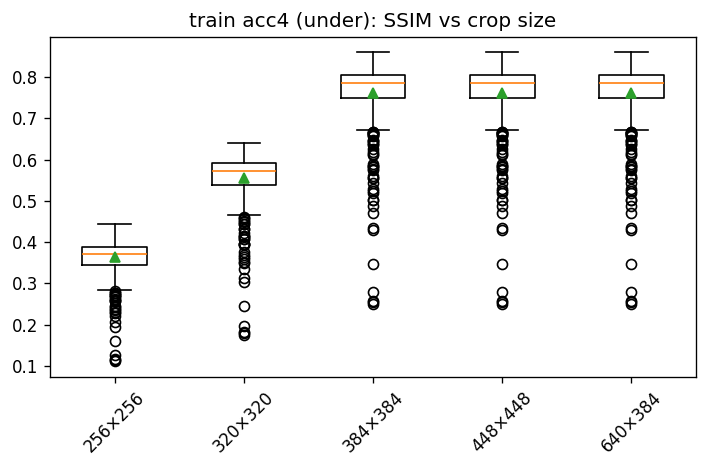

/tmp/ipykernel_14994/853005248.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showmeans=True)


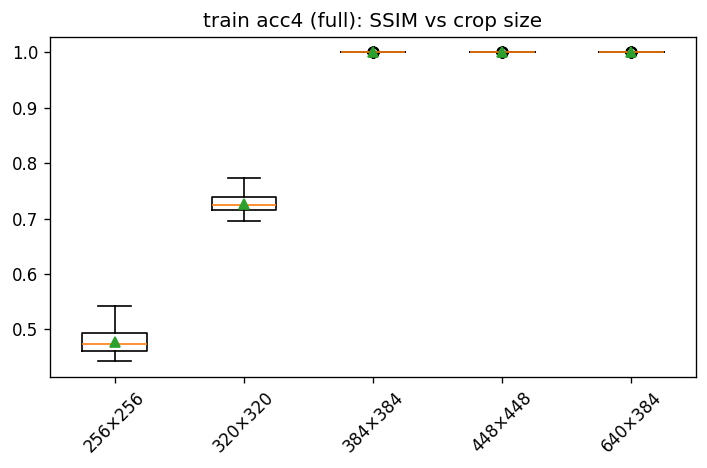

/tmp/ipykernel_14994/853005248.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showmeans=True)


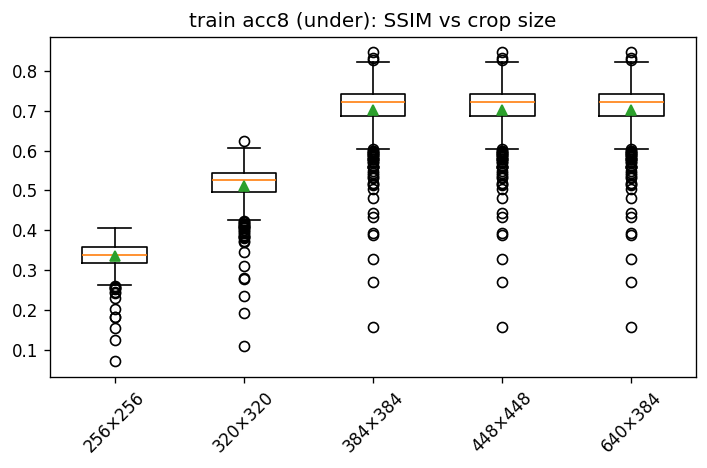

/tmp/ipykernel_14994/853005248.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showmeans=True)


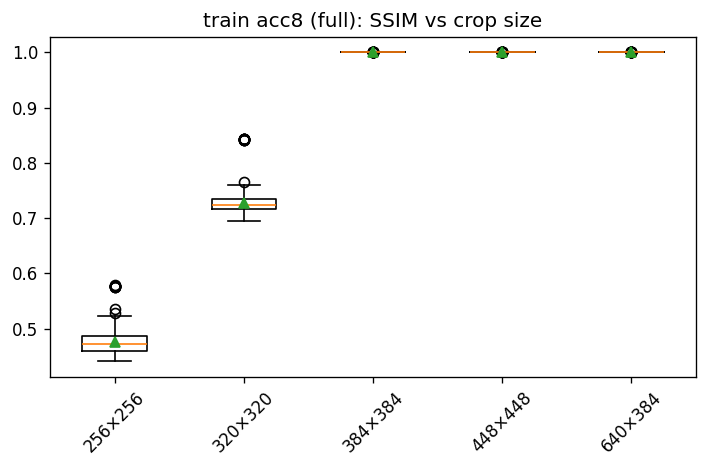

/tmp/ipykernel_14994/853005248.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showmeans=True)


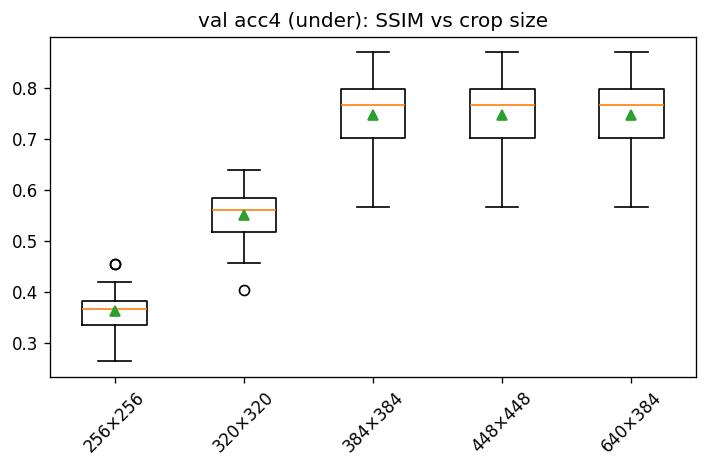

/tmp/ipykernel_14994/853005248.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showmeans=True)


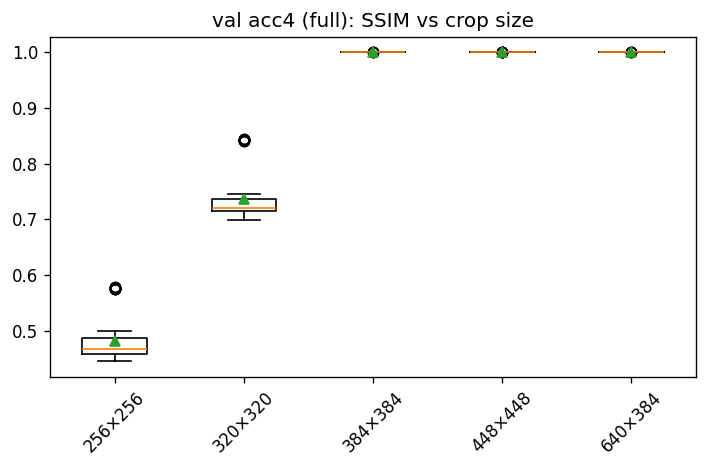

/tmp/ipykernel_14994/853005248.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showmeans=True)


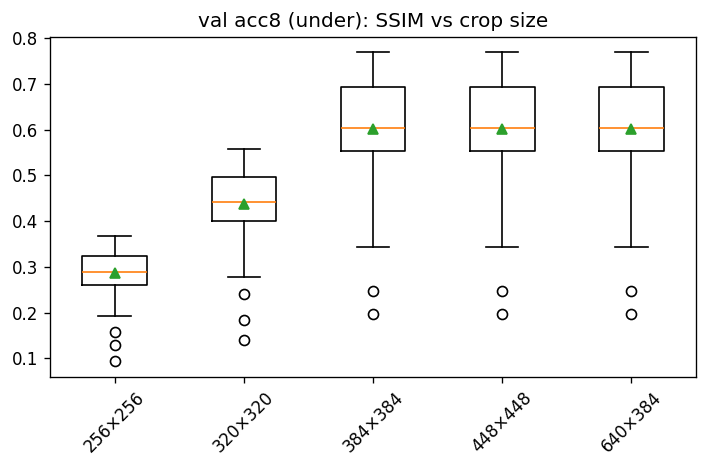

/tmp/ipykernel_14994/853005248.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showmeans=True)


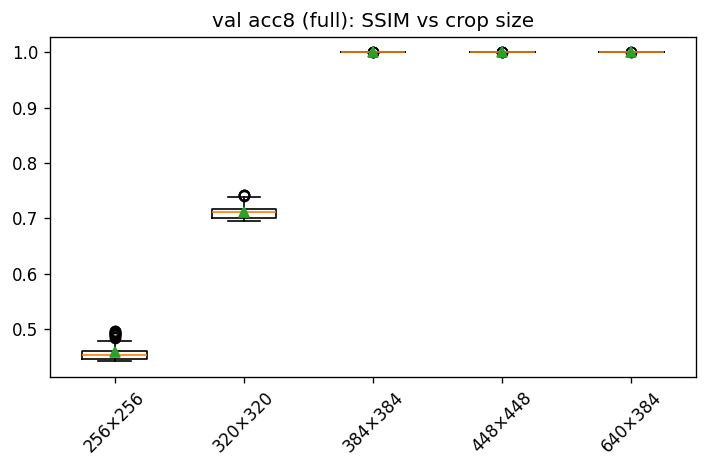

/tmp/ipykernel_14994/853005248.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showmeans=True)


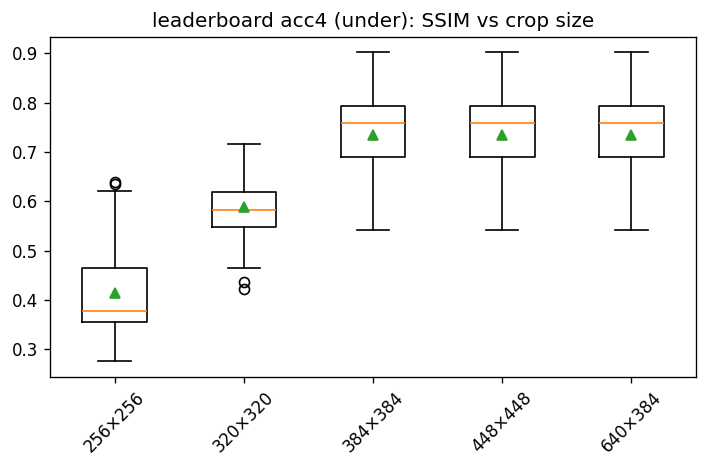

/tmp/ipykernel_14994/853005248.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showmeans=True)


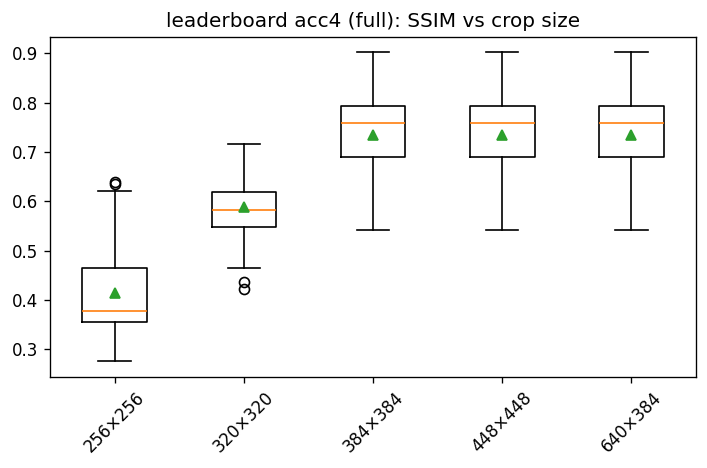

/tmp/ipykernel_14994/853005248.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showmeans=True)


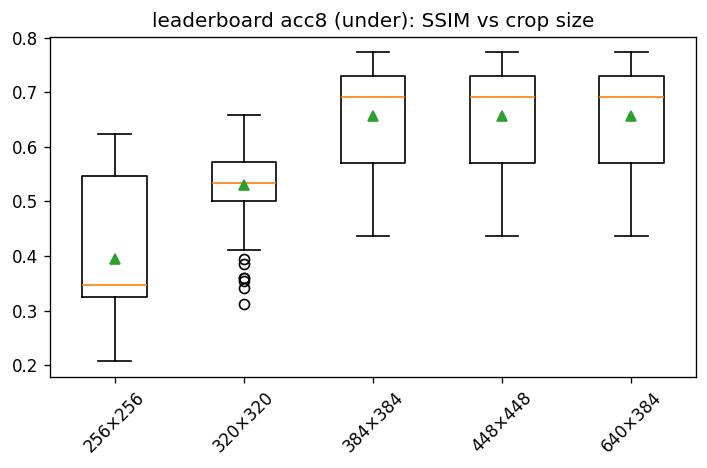

/tmp/ipykernel_14994/853005248.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showmeans=True)


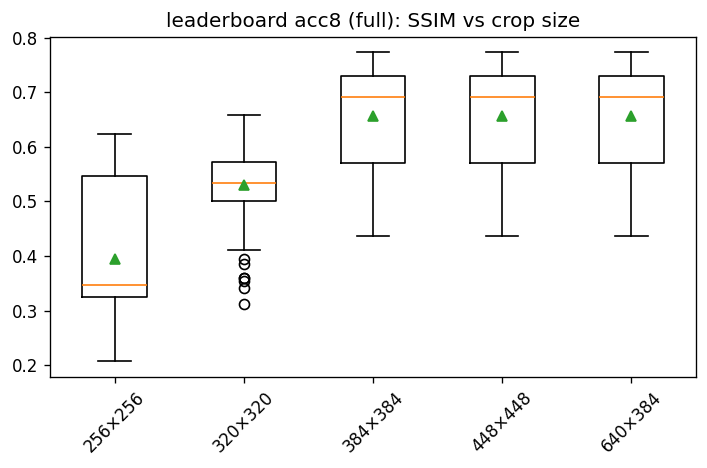

In [22]:
import random
from tqdm.auto import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
import h5py
import numpy as np

# (compute_recon, compute_ssim, center_crop_or_pad, CenterCropOrPad 등은 그대로 두세요)

random.seed(42)

splits       = ['train', 'val', 'leaderboard']
crop_sizes   = [(256,256), (320,320), (384,384), (448,448), (640,384)]
sample_ratio = 0.2

crop_ssim = defaultdict(list)
comp      = SCCCompressor(target_coils=4)

for sp in splits:
    for acc in ('4','8'):
        # 20% 볼륨 샘플링
        all_pairs = [
            (img_p, ks_p)
            for img_p, ks_p in zip(files[sp]['image'], files[sp]['kspace'])
            if f'acc{acc}' in ks_p
        ]
        sample_size   = max(1, int(len(all_pairs) * sample_ratio))
        sampled_pairs = random.sample(all_pairs, sample_size)

        for size in crop_sizes:
            ccp  = CenterCropOrPad(target_size=size)
            desc = f'{sp}-acc{acc}-crop{size} ({sample_size}/{len(all_pairs)})'
            for img_p, ks_p in tqdm(sampled_pairs, desc=desc):
                # --- Load ---
                with h5py.File(img_p,'r') as f_img:
                    key_img = 'image_label' if 'image_label' in f_img else 'image_grappa'
                    img_vol = f_img[key_img][()]

                with h5py.File(ks_p,'r') as f_ks:
                    ks_vol = f_ks['kspace'][()]
                    mask   = f_ks['mask'][()]

                # Undersampled k-space
                ks_under = ks_vol * mask[np.newaxis, np.newaxis, np.newaxis, :]

                for slice_idx in range(ks_vol.shape[0]):
                    gt = img_vol[slice_idx]

                    # 공통 to-torch mask
                    mask_t = torch.from_numpy(mask).float()

                    # --- undersampled case ---
                    k_u   = ks_under[slice_idx]
                    k_u_t = torch.from_numpy(k_u).to(torch.complex64)
                    # Crop
                    _, k2_u, *_ = ccp(mask_t, k_u_t, None, {}, '', slice_idx)
                    arr_u = k2_u.numpy()  # (C, Hc, Wc, 2)
                    # real/imag → complex
                    ks2u = arr_u[...,0] + 1j*arr_u[...,1]
                    # Recon
                    rec_u    = compute_recon(ks2u)                        # (Hc, Wc)
                    rec_u_sm = center_crop_or_pad(rec_u, gt.shape)       # (H_gt, W_gt)
                    crop_ssim[(sp, acc, 'under', size)].append(
                        compute_ssim(rec_u_sm, gt)
                    )

                    # --- fully-sampled case ---
                    k_f   = ks_vol[slice_idx]
                    k_f_t = torch.from_numpy(k_f).to(torch.complex64)
                    _, k2_f, *_ = ccp(mask_t, k_f_t, None, {}, '', slice_idx)
                    arr_f = k2_f.numpy()
                    ks2f  = arr_f[...,0] + 1j*arr_f[...,1]
                    rec_f    = compute_recon(ks2f)
                    rec_f_sm = center_crop_or_pad(rec_f, gt.shape)
                    crop_ssim[(sp, acc, 'full', size)].append(
                        compute_ssim(rec_f_sm, gt)
                    )

# Visualization (unchanged)
for sp in splits:
    for acc in ('4','8'):
        for case in ('under','full'):
            fig, ax = plt.subplots(figsize=(6,4))
            data   = [crop_ssim[(sp, acc, case, sz)] for sz in crop_sizes]
            labels = [f"{h}×{w}" for h,w in crop_sizes]
            ax.boxplot(data, labels=labels, showmeans=True)
            ax.set_title(f'{sp} acc{acc} ({case}): SSIM vs crop size')
            ax.tick_params(axis='x', rotation=45)
            plt.tight_layout()
            plt.show()


### 5) 각 파일 H/W 분포 분석

Dim scan [train/image]:   0%|          | 0/340 [00:00<?, ?it/s]

Dim scan [train/kspace]:   0%|          | 0/340 [00:00<?, ?it/s]

Dim scan [val/image]:   0%|          | 0/60 [00:00<?, ?it/s]

Dim scan [val/kspace]:   0%|          | 0/60 [00:00<?, ?it/s]

Dim scan [leaderboard/image]:   0%|          | 0/116 [00:00<?, ?it/s]

Dim scan [leaderboard/kspace]:   0%|          | 0/116 [00:00<?, ?it/s]

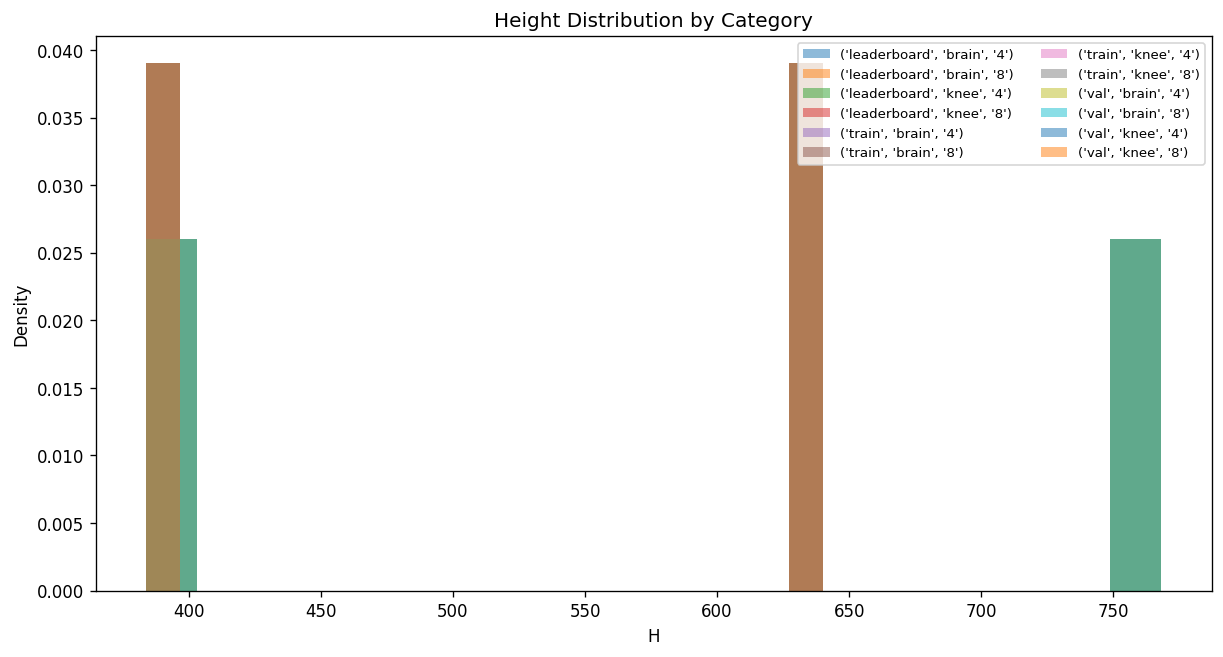

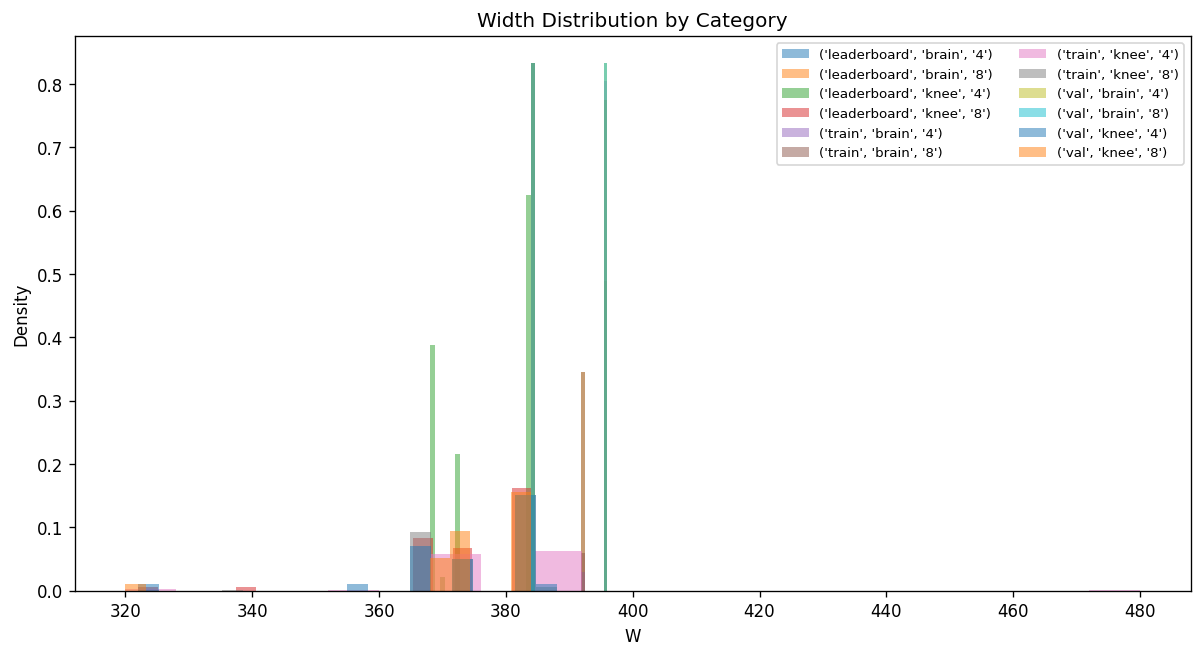

모든 파일의 H와 W가 짝수입니다.


In [24]:
import os
import h5py
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm

# 1) 파일별 H, W 수집 (tqdm 추가)
dim_stats = defaultdict(list)

for sp in splits:
    for dtype in ('image', 'kspace'):
        file_list = files[sp][dtype]
        desc = f"Dim scan [{sp}/{dtype}]"
        for p in tqdm(file_list, desc=desc):
            fname = os.path.basename(p)
            # 카테고리 추출
            m = REG.search(fname)
            if m:
                body, acc, idx = m.groups()
            else:
                m2 = LB_REG.search(fname)
                body, idx = m2.groups()
                acc = '4' if '/acc4/' in p else ('8' if '/acc8/' in p else '?')
            # 차원 확인
            with h5py.File(p, 'r') as f:
                if dtype == 'image':
                    key_img = 'image_label' if 'image_label' in f else 'image_grappa'
                    vol = f[key_img][()]           # (S, H, W)
                    H, W = vol.shape[1:]
                else:
                    vol = f['kspace'][()]          # (S, C, H, W)
                    H, W = vol.shape[2:]
            dim_stats[(sp, body, acc)].append((H, W))

# 2) 그래프: 각 카테고리별 H 및 W 히스토그램
categories = sorted(dim_stats.keys(), key=lambda x: (x[0], x[1], x[2]))

# Height 분포
plt.figure(figsize=(12, 6))
for key in categories:
    Hs = [hw[0] for hw in dim_stats[key]]
    plt.hist(Hs, bins=20, alpha=0.5, label=f"{key}", density=True)
plt.title('Height Distribution by Category')
plt.xlabel('H'); plt.ylabel('Density')
plt.legend(fontsize=8, ncol=2)
plt.show()

# Width 분포
plt.figure(figsize=(12, 6))
for key in categories:
    Ws = [hw[1] for hw in dim_stats[key]]
    plt.hist(Ws, bins=20, alpha=0.5, label=f"{key}", density=True)
plt.title('Width Distribution by Category')
plt.xlabel('W'); plt.ylabel('Density')
plt.legend(fontsize=8, ncol=2)
plt.show()

# 3) 짝수 여부 확인
all_even = True
for key, hw_list in dim_stats.items():
    for H, W in hw_list:
        if (H % 2 != 0) or (W % 2 != 0):
            all_even = False
            print(f"Odd dimension detected in {key}: H={H}, W={W}")
if all_even:
    print("모든 파일의 H와 W가 짝수입니다.")


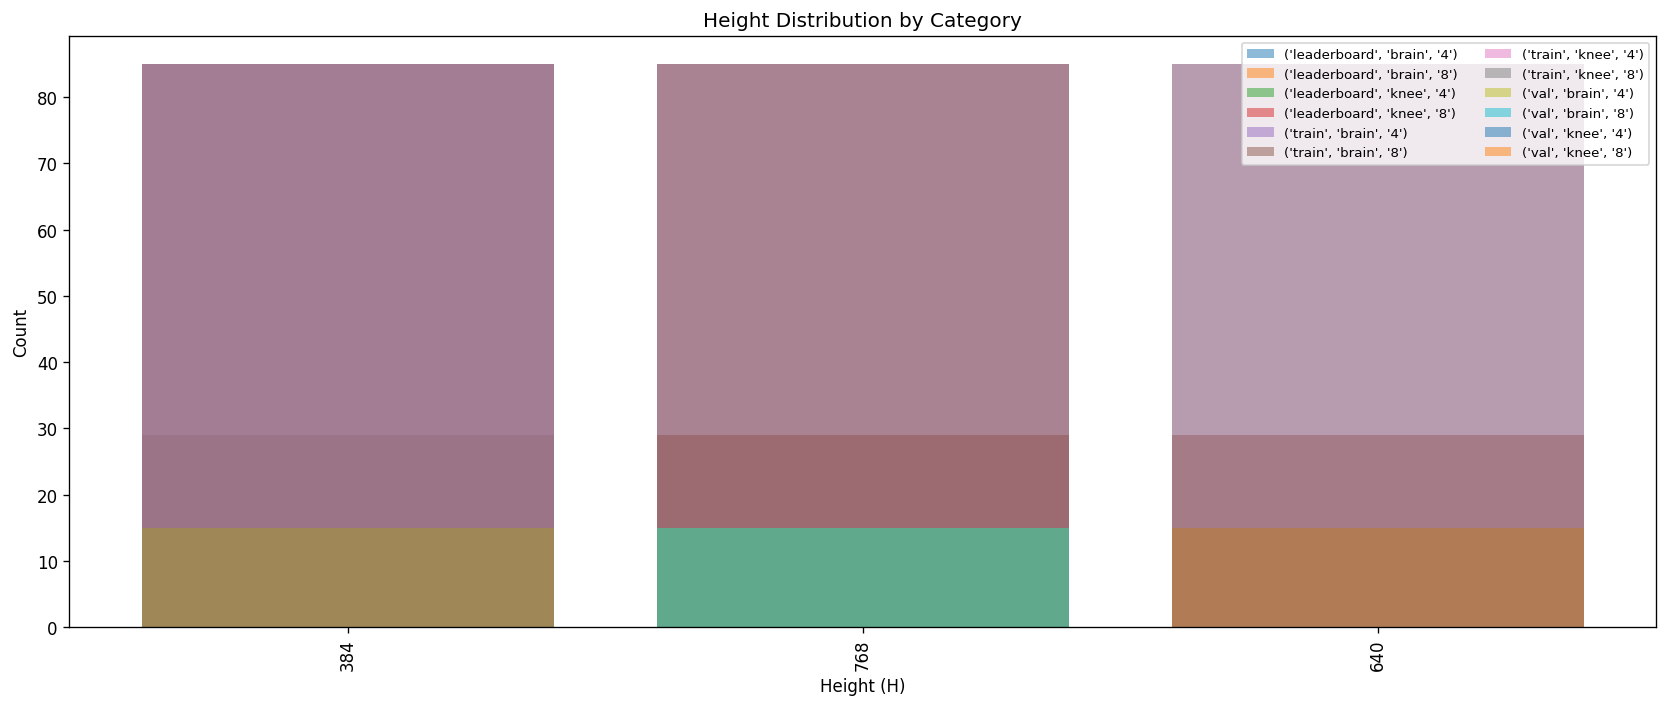

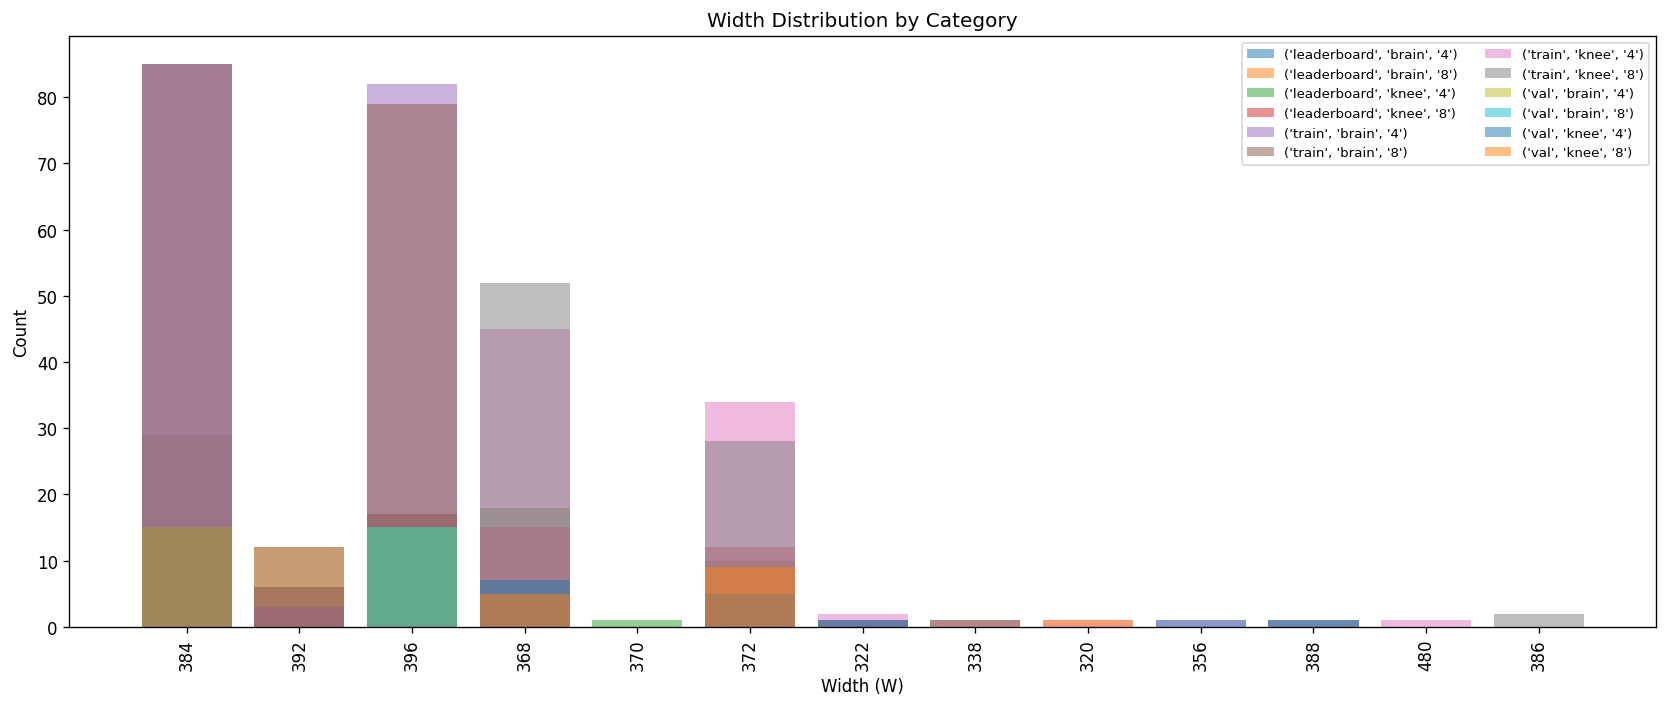

In [28]:

from collections import defaultdict, Counter
# 2) 카테고리 정렬
categories = sorted(dim_stats.keys(), key=lambda x:(x[0],x[1],x[2]))

# 3) Height 분포: categorical x-axis
plt.figure(figsize=(14,6))
for key in categories:
    Hs = [hw[0] for hw in dim_stats[key]]
    uniq, cnt = np.unique(Hs, return_counts=True)
    labels = [str(u) for u in uniq]
    plt.bar(labels, cnt, alpha=0.5, label=f"{key}", width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Height (H)')
plt.ylabel('Count')
plt.title('Height Distribution by Category')
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

# 4) Width 분포: categorical x-axis
plt.figure(figsize=(14,6))
for key in categories:
    Ws = [hw[1] for hw in dim_stats[key]]
    uniq, cnt = np.unique(Ws, return_counts=True)
    labels = [str(u) for u in uniq]
    plt.bar(labels, cnt, alpha=0.5, label=f"{key}", width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Width (W)')
plt.ylabel('Count')
plt.title('Width Distribution by Category')
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

아래 코드는 “단순히 SSIM 분포를 박스플롯으로 보는 것”을 넘어서, 각 (384,384)·(640,384) 크기에서 실제로 크롭으로 인한 SSIM 손실(ΔSSIM) 이 얼마나 발생하는지, 그리고 원본 해상도(H, W)가 크롭 크기보다 작은(→패드만) 경우와 큰(→크롭 발생) 경우를 나눠서 통계적으로 비교해 줍니다.

Baseline SSIM: 크롭을 전혀 하지 않았을 때 SSIM

Crop SSIM: (384,384), (640,384) 두 크기에 대해 크롭 적용 후 SSIM

ΔSSIM = Crop SSIM − Baseline SSIM

그룹 비교:

pad_only 그룹: H ≤ crop_H 그리고 W ≤ crop_W 이므로 패드만 발생

crop_happens 그룹: H > crop_H 또는 W > crop_W 이므로 실제 크롭 발생

결과 테이블: 각 그룹별 ΔSSIM 평균·표준편차·샘플 수

간단한 바 차트: 그룹별 평균 ΔSSIM 비교

train-acc4 sampling:   0%|          | 0/34 [00:00<?, ?it/s]

train-acc8 sampling:   0%|          | 0/34 [00:00<?, ?it/s]

val-acc4 sampling:   0%|          | 0/6 [00:00<?, ?it/s]

val-acc8 sampling:   0%|          | 0/6 [00:00<?, ?it/s]

leaderboard-acc4 sampling:   0%|          | 0/11 [00:00<?, ?it/s]

leaderboard-acc8 sampling:   0%|          | 0/11 [00:00<?, ?it/s]


=== Crop 384×384 ===
                            mean           std  count
case  group                                          
full  crop_happens -4.363842e-09  1.658217e-08   1504
under crop_happens -2.921587e-08  2.197581e-08   1504

=== Crop 640×384 ===
                            mean           std  count
case  group                                          
full  crop_happens -5.886662e-09  1.507821e-08    883
      pad_only     -1.806390e-09  1.293968e-08    621
under crop_happens -2.735289e-08  2.072804e-08    883
      pad_only     -1.890722e-08  1.613550e-08    621


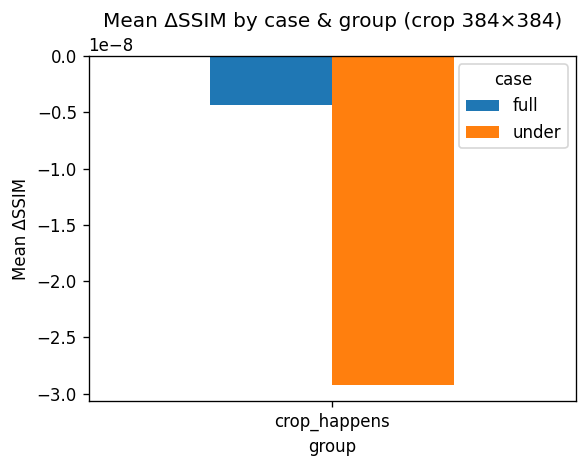

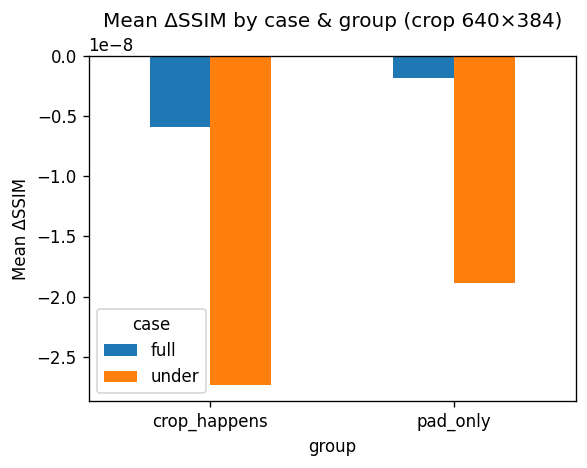

In [7]:
import random
from tqdm.auto import tqdm
from collections import defaultdict
import numpy as np
import torch
import h5py
import pandas as pd
import matplotlib.pyplot as plt

random.seed(42)

splits       = ['train', 'val', 'leaderboard']
accs         = ['4','8']
crop_sizes   = [(384,384), (640,384)]
sample_ratio = 0.2

records = []

for sp in splits:
    for acc in accs:
        # 20% 볼륨 샘플링
        all_pairs = [(img_p, ks_p) for img_p, ks_p 
                     in zip(files[sp]['image'], files[sp]['kspace'])
                     if f'acc{acc}' in ks_p]
        sample_size   = max(1, int(len(all_pairs)*sample_ratio))
        sampled_pairs = random.sample(all_pairs, sample_size)

        for img_p, ks_p in tqdm(sampled_pairs, desc=f'{sp}-acc{acc} sampling'):
            # Load volumes
            with h5py.File(img_p,'r') as f_img:
                key_img = 'image_label' if 'image_label' in f_img else 'image_grappa'
                img_vol = f_img[key_img][()]    # (S, H_gt, W_gt)
            with h5py.File(ks_p,'r') as f_ks:
                ks_vol = f_ks['kspace'][()]     # (S, C, Hk, Wk)
                mask   = f_ks['mask'][()]       # (Wk,)

            # 두 case 준비
            ks_under = ks_vol * mask[np.newaxis,None,None,:]
            ks_full  = ks_vol

            for slice_idx in range(ks_vol.shape[0]):
                gt = img_vol[slice_idx]
                # 원본 k-space/이미지 크기
                Hk, Wk = ks_vol.shape[2], ks_vol.shape[3]

                for case, ks_in in (('under', ks_under), ('full', ks_full)):
                    # Baseline (no crop)
                    rec_base = compute_recon(ks_in[slice_idx])
                    rec_base = center_crop_or_pad(rec_base, gt.shape)
                    s_base   = compute_ssim(rec_base, gt)

                    mask_t = torch.from_numpy(mask).float()
                    k_t    = torch.from_numpy(ks_in[slice_idx]).to(torch.complex64)

                    for (cH, cW) in crop_sizes:
                        ccp = CenterCropOrPad(target_size=(cH,cW))
                        _, k2, *_ = ccp(mask_t, k_t, None, {}, '', slice_idx)
                        arr = k2.numpy()
                        ks2 = arr[...,0] + 1j*arr[...,1]

                        rec_crop = compute_recon(ks2)
                        rec_crop = center_crop_or_pad(rec_crop, gt.shape)
                        s_crop   = compute_ssim(rec_crop, gt)

                        # group 구분: k-space / image 크기와 비교
                        if Hk <= cH and Wk <= cW:
                            group = 'pad_only'
                        else:
                            group = 'crop_happens'

                        records.append({
                            'split':    sp,
                            'acc':      acc,
                            'case':     case,
                            'slice':    slice_idx,
                            'Hk':       Hk,
                            'Wk':       Wk,
                            'crop_H':   cH,
                            'crop_W':   cW,
                            'group':    group,
                            'ssim_base':s_base,
                            'ssim_crop':s_crop,
                            'delta':    s_crop - s_base
                        })

# DataFrame 생성
df = pd.DataFrame(records)

# 결과 확인
for cH, cW in crop_sizes:
    print(f"\n=== Crop {cH}×{cW} ===")
    sub = df[(df.crop_H==cH)&(df.crop_W==cW)]
    summary = sub.groupby(['case','group'])['delta'].agg(['mean','std','count'])
    print(summary)

# 시각화
for cH, cW in crop_sizes:
    sub = df[(df.crop_H==cH)&(df.crop_W==cW)]
    pivot = sub.pivot_table(index='group', columns='case', values='delta', aggfunc='mean')
    pivot.plot(kind='bar', figsize=(5,4), rot=0)
    plt.title(f'Mean ΔSSIM by case & group (crop {cH}×{cW})')
    plt.ylabel('Mean ΔSSIM')
    plt.tight_layout()
    plt.show()



=== Crop 384×384 ===
                            mean           std  count
case  group                                          
full  crop_happens -4.363842e-09  1.658217e-08   1504
under crop_happens -2.921587e-08  2.197581e-08   1504

=== Crop 640×384 ===
                            mean           std  count
case  group                                          
full  crop_happens -5.886662e-09  1.507821e-08    883
      pad_only     -1.806390e-09  1.293968e-08    621
under crop_happens -2.735289e-08  2.072804e-08    883
      pad_only     -1.890722e-08  1.613550e-08    621


<Figure size 720x480 with 0 Axes>

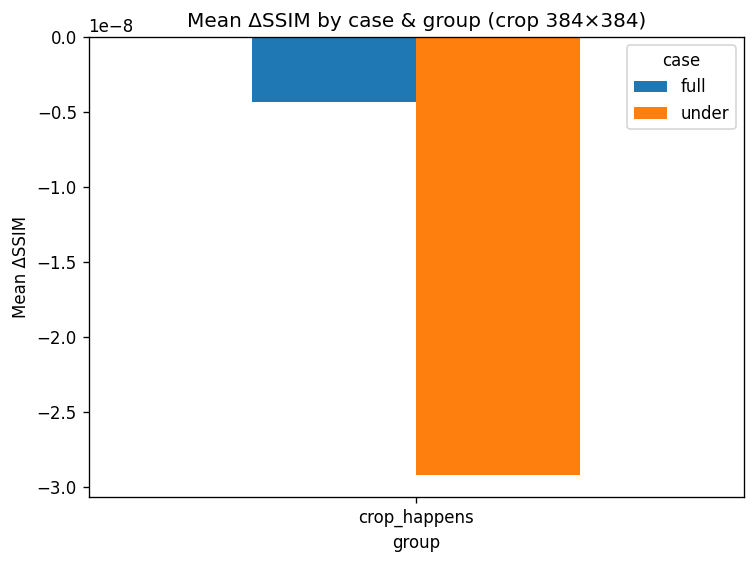

<Figure size 720x480 with 0 Axes>

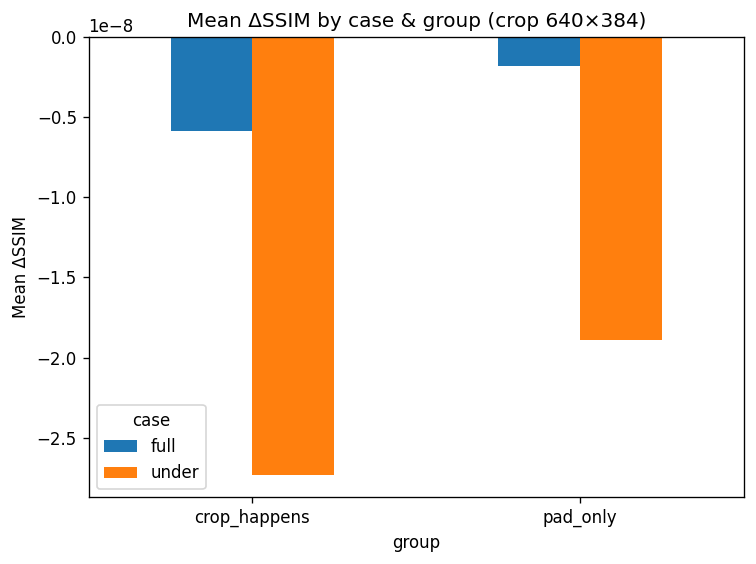

In [8]:

# DataFrame
df = pd.DataFrame(records)

# 그룹×case별 요약
for cH, cW in crop_sizes:
    print(f"\n=== Crop {cH}×{cW} ===")
    sub = df[(df.crop_H==cH)&(df.crop_W==cW)]
    summary = sub.groupby(['case','group'])['delta'].agg(['mean','std','count'])
    print(summary)

# 시각화: case별 그룹 평균 ΔSSIM 바 차트
for cH, cW in crop_sizes:
    sub = df[(df.crop_H==cH)&(df.crop_W==cW)]
    plt.figure(figsize=(6,4))
    # 피벗 테이블로 재구성
    pivot = sub.pivot_table(index='group', columns='case', values='delta', aggfunc='mean')
    pivot.plot(kind='bar', rot=0)
    plt.title(f'Mean ΔSSIM by case & group (crop {cH}×{cW})')
    plt.ylabel('Mean ΔSSIM')
    plt.tight_layout()
    plt.show()
